### Project Detail
- ### Name : GER Detection
- ### Dec 2023


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from IPython.display import IFrame
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump, load
from ydata_profiling import ProfileReport


# Functions

In [ ]:
# Standard Scaling of signals
def standard_scaling_signal(signal, sensor, training=True):
    try: # reshapeing the signal for scaling
        signal.shape[1]
    except:
        signal = signal.reshape(-1,1)

    if training:
        sc = StandardScaler()
        scaled_signal = sc.fit_transform(signal)
        dump(sc, f"standard_scaler_sig_{sensor}.joblib")
        return scaled_signal.reshape(1,-1)[0]

    if not training:
        sc = load(f"standard_scaler_sig_{sensor}.joblib")
        scaled_signal = sc.transform(signal)
        return scaled_signal.reshape(1,-1)[0]


# Segmenting the signals
def segmenting_signal(signal, frame_size, hop_length):
    temp_sig = []
    lower_cut = 0
    upper_cut = frame_size

    while True:
        if upper_cut > signal.shape[0]:
            break

        segmented_sig = signal[lower_cut: upper_cut]
        temp_sig.append(segmented_sig)

        # taking one step forther
        lower_cut += hop_length
        upper_cut = lower_cut + frame_size

    return pd.DataFrame(temp_sig)


# calculate the length of the reflux
def start_length_value(lable_matrix):
    lable_matrix["length"] = lable_matrix.iloc[:,:].sum(axis=1)
    return lable_matrix


# extracting moving average signal
def moving_average(signal, window_size):
    if len(signal) < window_size:
        raise ValueError("Window size must be less than or equal to the length of the signal.")
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(signal, weights, mode='valid')
    moving_avg = np.concatenate((moving_avg, np.zeros(window_size-1)))
    return moving_avg

# Preprocessing

In [ ]:
signal_df = pd.read_csv("IMPEDANCE_Train.csv", names=["1", "2","3","4", "5", "6"])
label_df = pd.read_csv("FLAG_GER_Train.csv", names=["1", "2","3","4", "5", "6"])

# Constants of program
FRAME_SIZE = 128
HOP_LENGTH_TRAIN = 16
HOP_LENGTH_TEST = 128
SENSORS = [6,5,4,3,2,1]

# creating the dataset
df = pd.DataFrame()
df["signal_6"] = signal_df.iloc[:, 0]
df["signal_5"] = signal_df.iloc[:, 1]
df["signal_4"] = signal_df.iloc[:, 2]
df["signal_3"] = signal_df.iloc[:, 3]
df["signal_2"] = signal_df.iloc[:, 4]
df["signal_1"] = signal_df.iloc[:, 5]
df["lable_6"] = label_df.iloc[:, 0]
df["lable_5"] = label_df.iloc[:, 1]
df["lable_4"] = label_df.iloc[:, 2]
df["lable_3"] = label_df.iloc[:, 3]
df["lable_2"] = label_df.iloc[:, 4]
df["lable_1"] = label_df.iloc[:, 5]
print("1_Creating the dataset is finished.")


# pre processing for misslables
lables = df.iloc[:, 6:12].values
missed_lables = 0
for col in range(5, -1, -1):
    for row in range(0, df.shape[0]):
        if lables[row, col] == 1:
            for i in range(col, -1, -1):
                if lables[row, i] == 0:
                    lables[row, i] = 1
                    missed_lables += 1
df.loc[:, ["lable_6", "lable_5", "lable_4", "lable_3", "lable_2", "lable_1"]]= lables
print("2_Preprocessing for misslabels is finished.")


# Splitting the Dataset
train_size = 0.9
cut_off = int(df.shape[0] * train_size)
df_train = df.iloc[:cut_off, :]
df_val = df.iloc[cut_off: , :]


WINDOW_SIZE = 32
# Scaling and denoising the training and validation signals sperately
for i in range(1, 7):
    df_train.loc[:, f"signal_{i}"] = standard_scaling_signal(df_train.loc[:,
                                                                        f"signal_{i}"].values,
                                                             sensor=i,
                                                             training=True)
    df_train.loc[:, f"signal_{i}"] = moving_average(df_train.loc[:, f"signal_{i}"].values,
                                                    WINDOW_SIZE)

    df_val.loc[:, f"signal_{i}"] = standard_scaling_signal(signal=df_val.loc[:,
                                                                             f"signal_{i}"].values,
                                                            sensor=i,
                                                            training=False)
    df_val.loc[:, f"signal_{i}"] = moving_average(df_val.loc[:, f"signal_{i}"].values,
                                                    WINDOW_SIZE)


print("4_Scaling process is finished.")


# Segmenting the signal
tr_segmented_sig_list = []
val_segmented_sig_list = []
for i in range(1,7):
    tr_segmented_sig_list.append(segmenting_signal(df_train[f"signal_{i}"].values,
                                                   frame_size=FRAME_SIZE,
                                                   hop_length=HOP_LENGTH_TRAIN))
    val_segmented_sig_list.append(segmenting_signal(df_val[f"signal_{i}"].values,
                                                   frame_size=FRAME_SIZE,
                                                   hop_length=HOP_LENGTH_TEST))

print("5_Segmenting signal process is finished.")


1_Creating the dataset is finished.
2_Preprocessing for misslabels is finished.
4_Scaling process is finished.
5_Segmenting signal process is finished.


# Training CNNs

In [ ]:
for sensor in SENSORS: # this procedure is apply for each labels
    # segmenting the labels
    tr_segmented_lable = segmenting_signal(df_train[f"lable_{sensor}"].values,
                                           frame_size=FRAME_SIZE,
                                           hop_length=HOP_LENGTH_TRAIN)
    val_segmented_lable = segmenting_signal(df_val[f"lable_{sensor}"].values,
                                          frame_size=FRAME_SIZE,
                                          hop_length=HOP_LENGTH_TEST)


    tr_segmented_lable = start_length_value(tr_segmented_lable)
    tr_segmented_lable.loc[tr_segmented_lable.length>=1, "length"] = 1
    val_segmented_lable = start_length_value(val_segmented_lable)
    val_segmented_lable.loc[val_segmented_lable.length>=1, "length"] = 1
    print(f"6_Segmenting label_{sensor} is finished")


    # creating a tensor of signals for training
    tensor = []
    for i in range(tr_segmented_sig_list[0].shape[0]):
        matrix = []
        for sig in [0, 1, 2, 3, 4, 5]: # we can choose which ever we want to select
            matrix.append(tr_segmented_sig_list[sig].iloc[i, :].values)
        tensor.append(matrix)
    training_tensor_dataset = np.array(tensor)
    y_train_length = tr_segmented_lable.length.values
    print(f"8_Training Tensor for Label_{sensor} is ready.")


    # creating a tensor of signal for validation
    tensor = []
    for i in range(val_segmented_sig_list[0].shape[0]):
        matrix = []
        for sig in [0, 1, 2, 3, 4, 5]: # we can choose which ever we want to select
            matrix.append(val_segmented_sig_list[sig].iloc[i, :].values)
        tensor.append(matrix)
    validation_tensor_dataset = np.array(tensor)
    y_val_length = val_segmented_lable.length.values


    # Create and Training the model
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    model = models.Sequential()
    model.add(layers.Conv2D(filters=20,
                            kernel_size=(training_tensor_dataset.shape[1], 1),
                            activation=tf.keras.activations.relu,
                            input_shape=(training_tensor_dataset.shape[1],
                                         training_tensor_dataset.shape[2],
                                         1),
                            padding="same"))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    training_tensor_dataset = training_tensor_dataset.reshape((training_tensor_dataset.shape[0],
                                                               training_tensor_dataset.shape[1],
                                                               training_tensor_dataset.shape[2],
                                                               1))
    op = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
    model.compile(optimizer=op,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    class_weights=compute_class_weight('balanced',
                                         classes=np.unique(y_train_length),
                                         y=y_train_length)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.7,
                                        patience=5,
                                        min_lr=1e-5,
                                        verbose=1)


    class_weight_dict=dict(enumerate(class_weights))
    model.fit(training_tensor_dataset,
              y_train_length,
              epochs=30,
              batch_size=1024,
              validation_data=(validation_tensor_dataset, y_val_length),
              callbacks=[reduce_lr])
    tf.keras.models.save_model(model, f"model_{sensor}.keras")


    print(f"""======================== 11_The model {sensor} is trained and stored ==================================.
          """)
    print("\n\n\n\n\n")

6_Segmenting label_6 is finished
8_Training Tensor for Label_6 is ready.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/30
49/49 [==============================] - 4s 80ms/step - loss: 0.4029 - accuracy: 0.8486 - val_loss: 0.3257 - val_accuracy: 0.8970 - lr: 5.0000e-04
Epoch 2/30
49/49 [==============================] - 4s 82ms/step - loss: 0.3204 - accuracy: 0.8863 - val_loss: 0.2795 - val_accuracy: 0.9100 - lr: 5.0000e-04
Epoch 3/30
49/49 [==============================] - 4s 79ms/step - loss: 0.2696 - accuracy: 0.9059 - val_loss: 0.2364 - val_accuracy: 0.9129 - lr: 5.0000e-04
Epoch 4/30
49/49 [==============================] - 4s 83ms/step - loss: 0.2515 - accuracy: 0.9132 - val_loss: 0.2223 - val_accuracy: 0.9260 - lr: 5.0000e-04
Epoch 5/30
49/49 [==============================] - 4s 85ms/step - loss: 0.2461 - accuracy: 0.9142 - val_loss: 0.2194 - val_accuracy: 0.9260 - lr: 5.0000e-04
Epoch 6/30
49/49 [==============================] - 4s 84ms/step - loss: 0.

49/49 [==============================] - 3s 71ms/step - loss: 0.1604 - accuracy: 0.9425 - val_loss: 0.1396 - val_accuracy: 0.9536 - lr: 5.0000e-04
Epoch 6/30
49/49 [==============================] - 3s 72ms/step - loss: 0.1565 - accuracy: 0.9429 - val_loss: 0.1404 - val_accuracy: 0.9521 - lr: 5.0000e-04
Epoch 7/30
49/49 [==============================] - 4s 73ms/step - loss: 0.1551 - accuracy: 0.9428 - val_loss: 0.1435 - val_accuracy: 0.9507 - lr: 5.0000e-04
Epoch 8/30
49/49 [==============================] - 4s 75ms/step - loss: 0.1537 - accuracy: 0.9430 - val_loss: 0.1426 - val_accuracy: 0.9492 - lr: 5.0000e-04
Epoch 9/30
49/49 [==============================] - 4s 73ms/step - loss: 0.1518 - accuracy: 0.9437 - val_loss: 0.1365 - val_accuracy: 0.9521 - lr: 5.0000e-04
Epoch 10/30
49/49 [==============================] - 4s 75ms/step - loss: 0.1511 - accuracy: 0.9433 - val_loss: 0.1320 - val_accuracy: 0.9521 - lr: 5.0000e-04
Epoch 11/30
49/49 [==============================] - 4s 78ms/s

# Preprocessing on Test-set

In [ ]:
signal_df = pd.read_csv("IMPEDANCE_Test.csv",
                        names=["1", "2","3","4", "5", "6"])
df_test = pd.DataFrame()
df_test["signal_6"] = signal_df.iloc[:, 0]
df_test["signal_5"] = signal_df.iloc[:, 1]
df_test["signal_4"] = signal_df.iloc[:, 2]
df_test["signal_3"] = signal_df.iloc[:, 3]
df_test["signal_2"] = signal_df.iloc[:, 4]
df_test["signal_1"] = signal_df.iloc[:, 5]
df_test

# Scaling dataset
for i in range(1, 7):
    df_test.loc[:, f"signal_{i}"] = standard_scaling_signal(signal=df_test.loc[:,
                                                                     f"signal_{i}"].values,
                                                            sensor=i,
                                                            training=False)
missed_data = df_test.iloc[df_test.shape[0]-31:].values

# aplying moving average on signal to reduce noises
for i in range(1, 7):
    df_test.loc[:, f"signal_{i}"] = moving_average(df_test.loc[:, f"signal_{i}"].values,
                                                    32)
df_test.loc[df_test.shape[0]-31:] = missed_data

# Inferencing on Test-set

In [ ]:
FRAME_SIZE = 128
HOP_LENGTH = 16
TRESHOLD = 0.6
MEAN_PROPOTION = FRAME_SIZE / HOP_LENGTH

# Creating the tensors of signals to feed the models
tensor = []
number_of_iters = int((df_test.shape[0] - FRAME_SIZE) / HOP_LENGTH)
number_of_iters
for step in range(number_of_iters):
    upper_cut = step * HOP_LENGTH + FRAME_SIZE
    lower_cut = upper_cut - FRAME_SIZE
    seg_signal = df_test.iloc[lower_cut: upper_cut, :6].T.iloc[::-1].values
    tensor.append(seg_signal)
tensor = np.array(tensor)


# Creating predition for all sensors
df_labels = pd.DataFrame()
for sensor in SENSORS:
    model_1 = tf.keras.models.load_model(f"model_{sensor}.keras")
    prediction_proba = model_1.predict(tensor)
    prediction_proba = prediction_proba[:, 0]
    signal_lable = np.zeros(df_test.shape[0])

    # predicting on overlaping Frames to improving the results
    for step in range(number_of_iters):
        upper_cut = step * HOP_LENGTH + FRAME_SIZE
        lower_cut = upper_cut - FRAME_SIZE
        pred = prediction_proba[step]
        if pred > TRESHOLD:
            prediction_vec = np.ones(FRAME_SIZE)
        else:
            prediction_vec = np.zeros(FRAME_SIZE)
        signal_lable[lower_cut: upper_cut] += prediction_vec

    signal_lable = signal_lable / MEAN_PROPOTION
    y_pred = (signal_lable>.1).astype(int)
    df_labels[f"label_{sensor}"] = y_pred



317/317 [==============================] - 1s 2ms/step


In [ ]:
df_labels.to_csv("FLAG_GER_Test.csv", index=False, header=False)

# Signal 6 Visualization

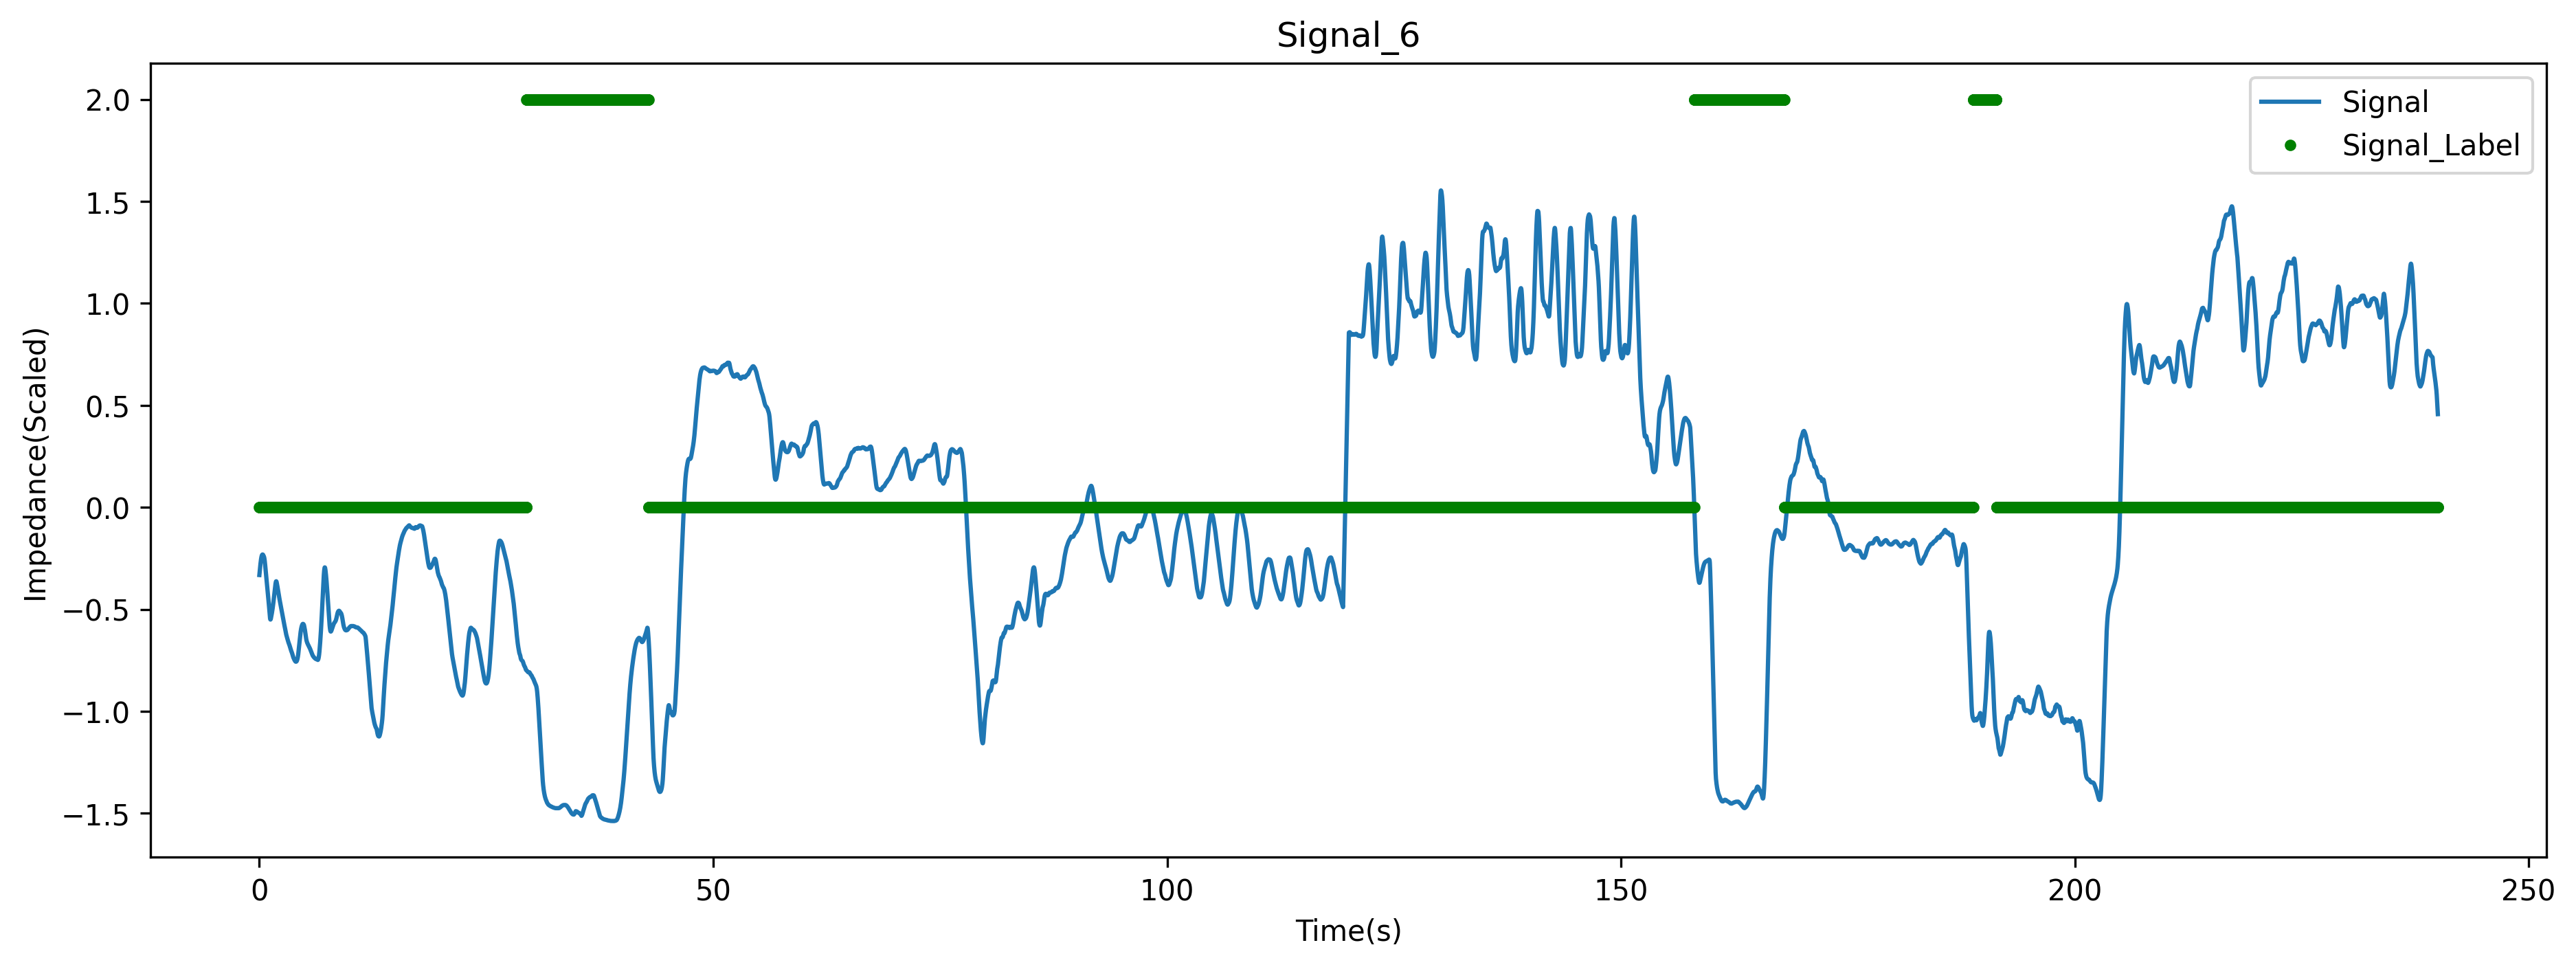

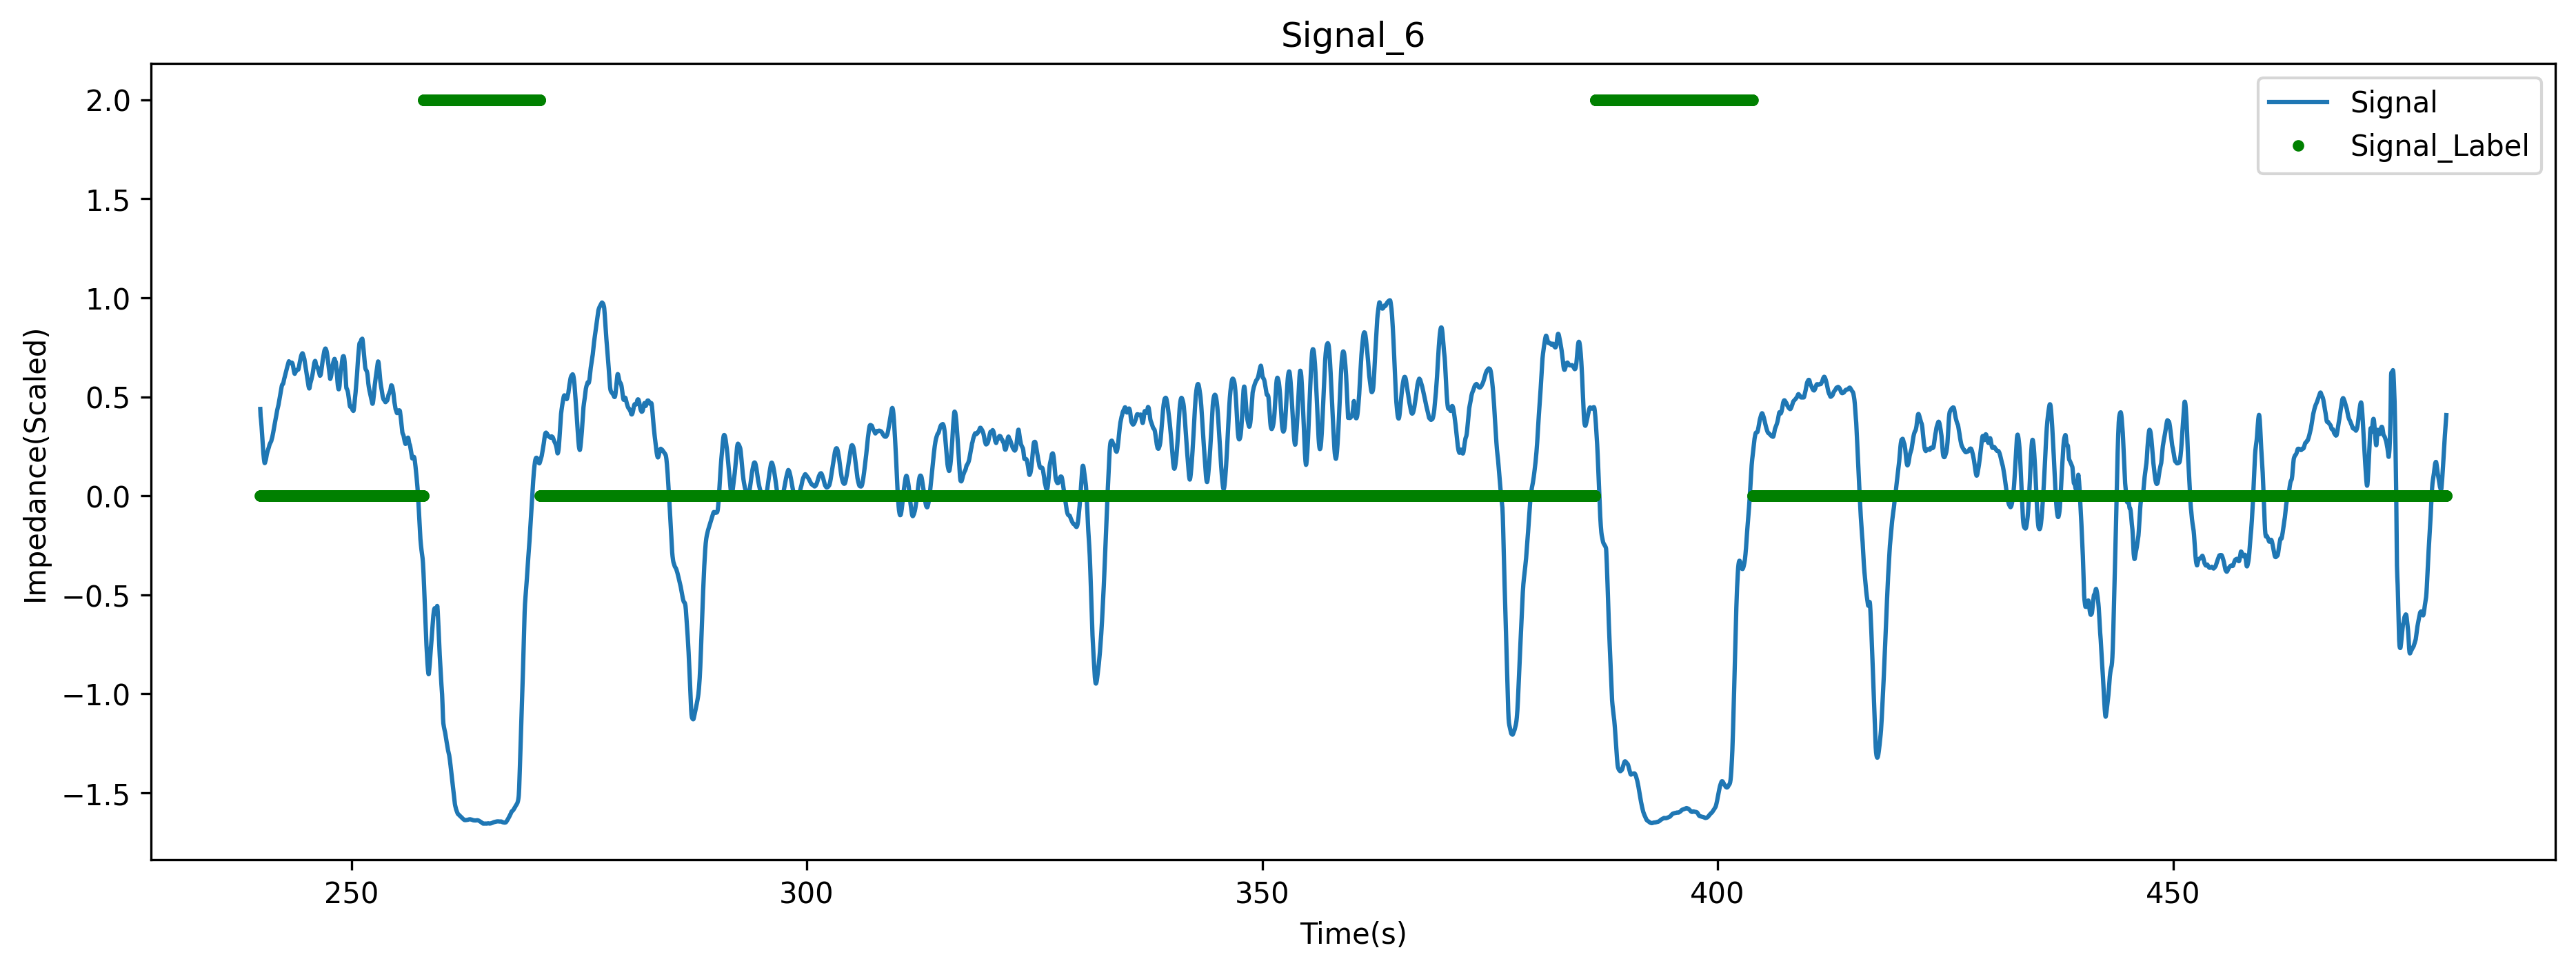

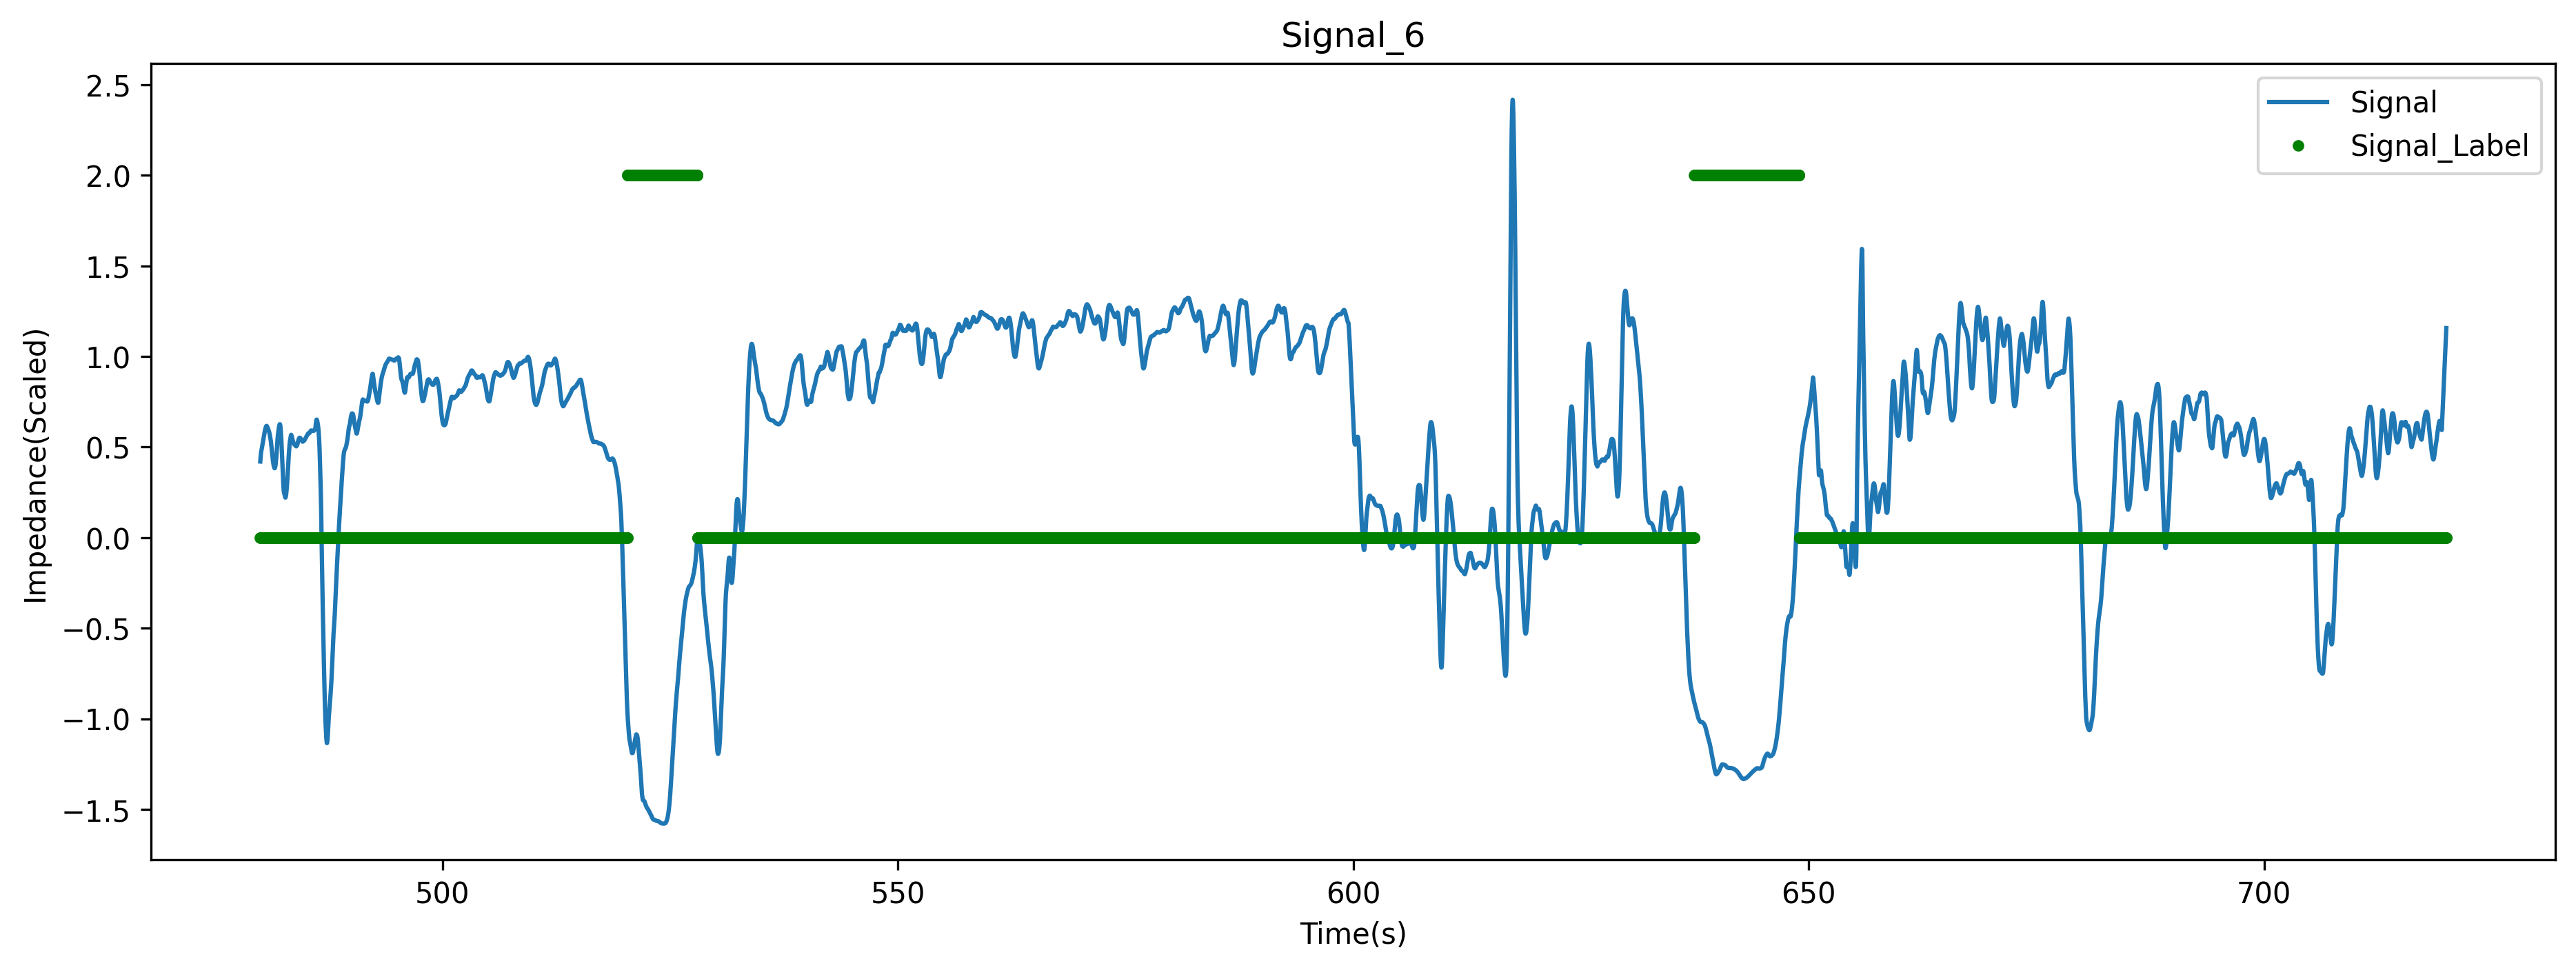

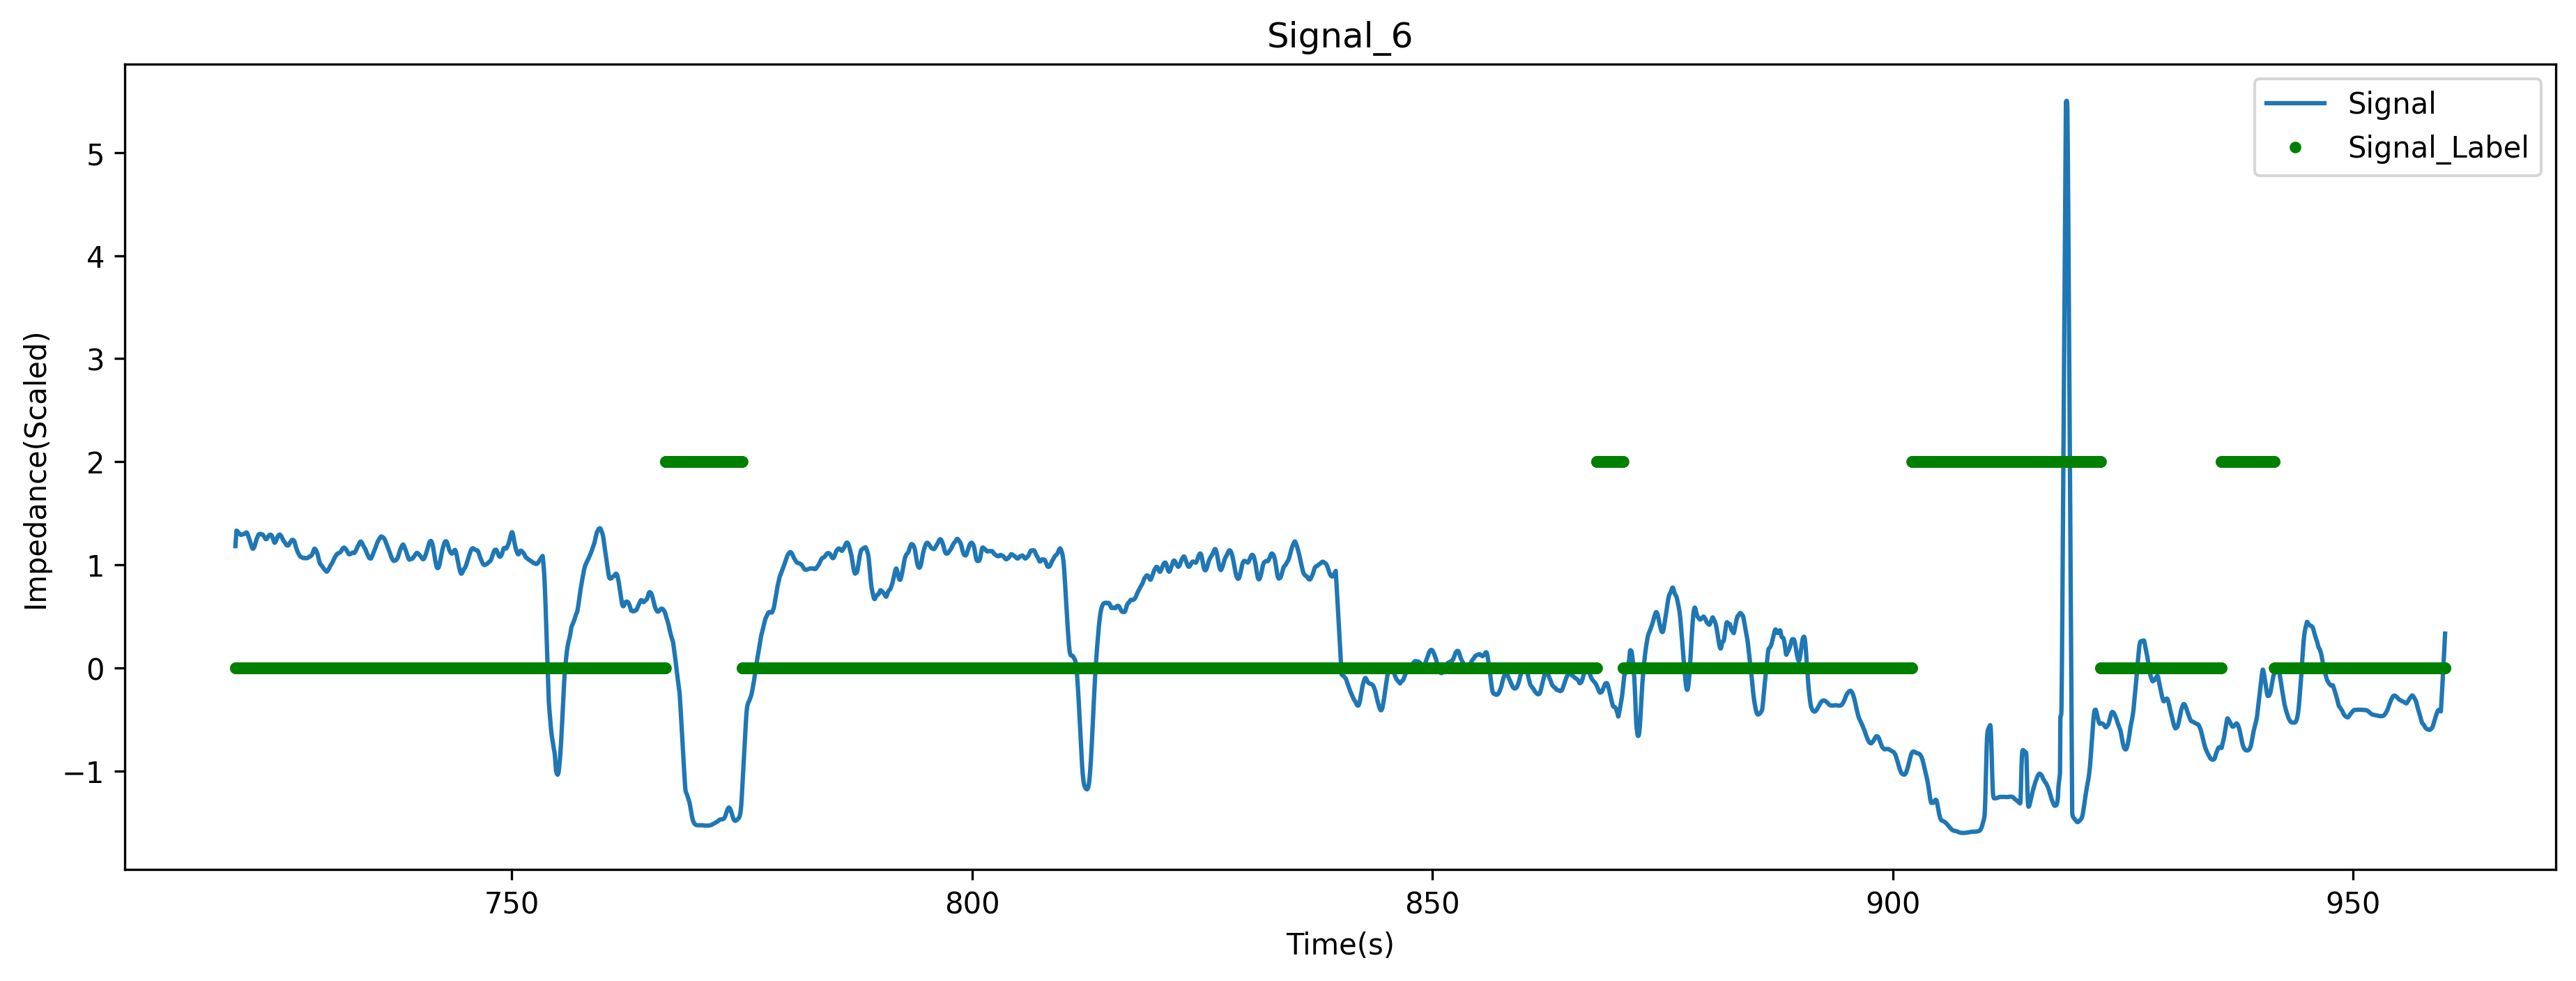

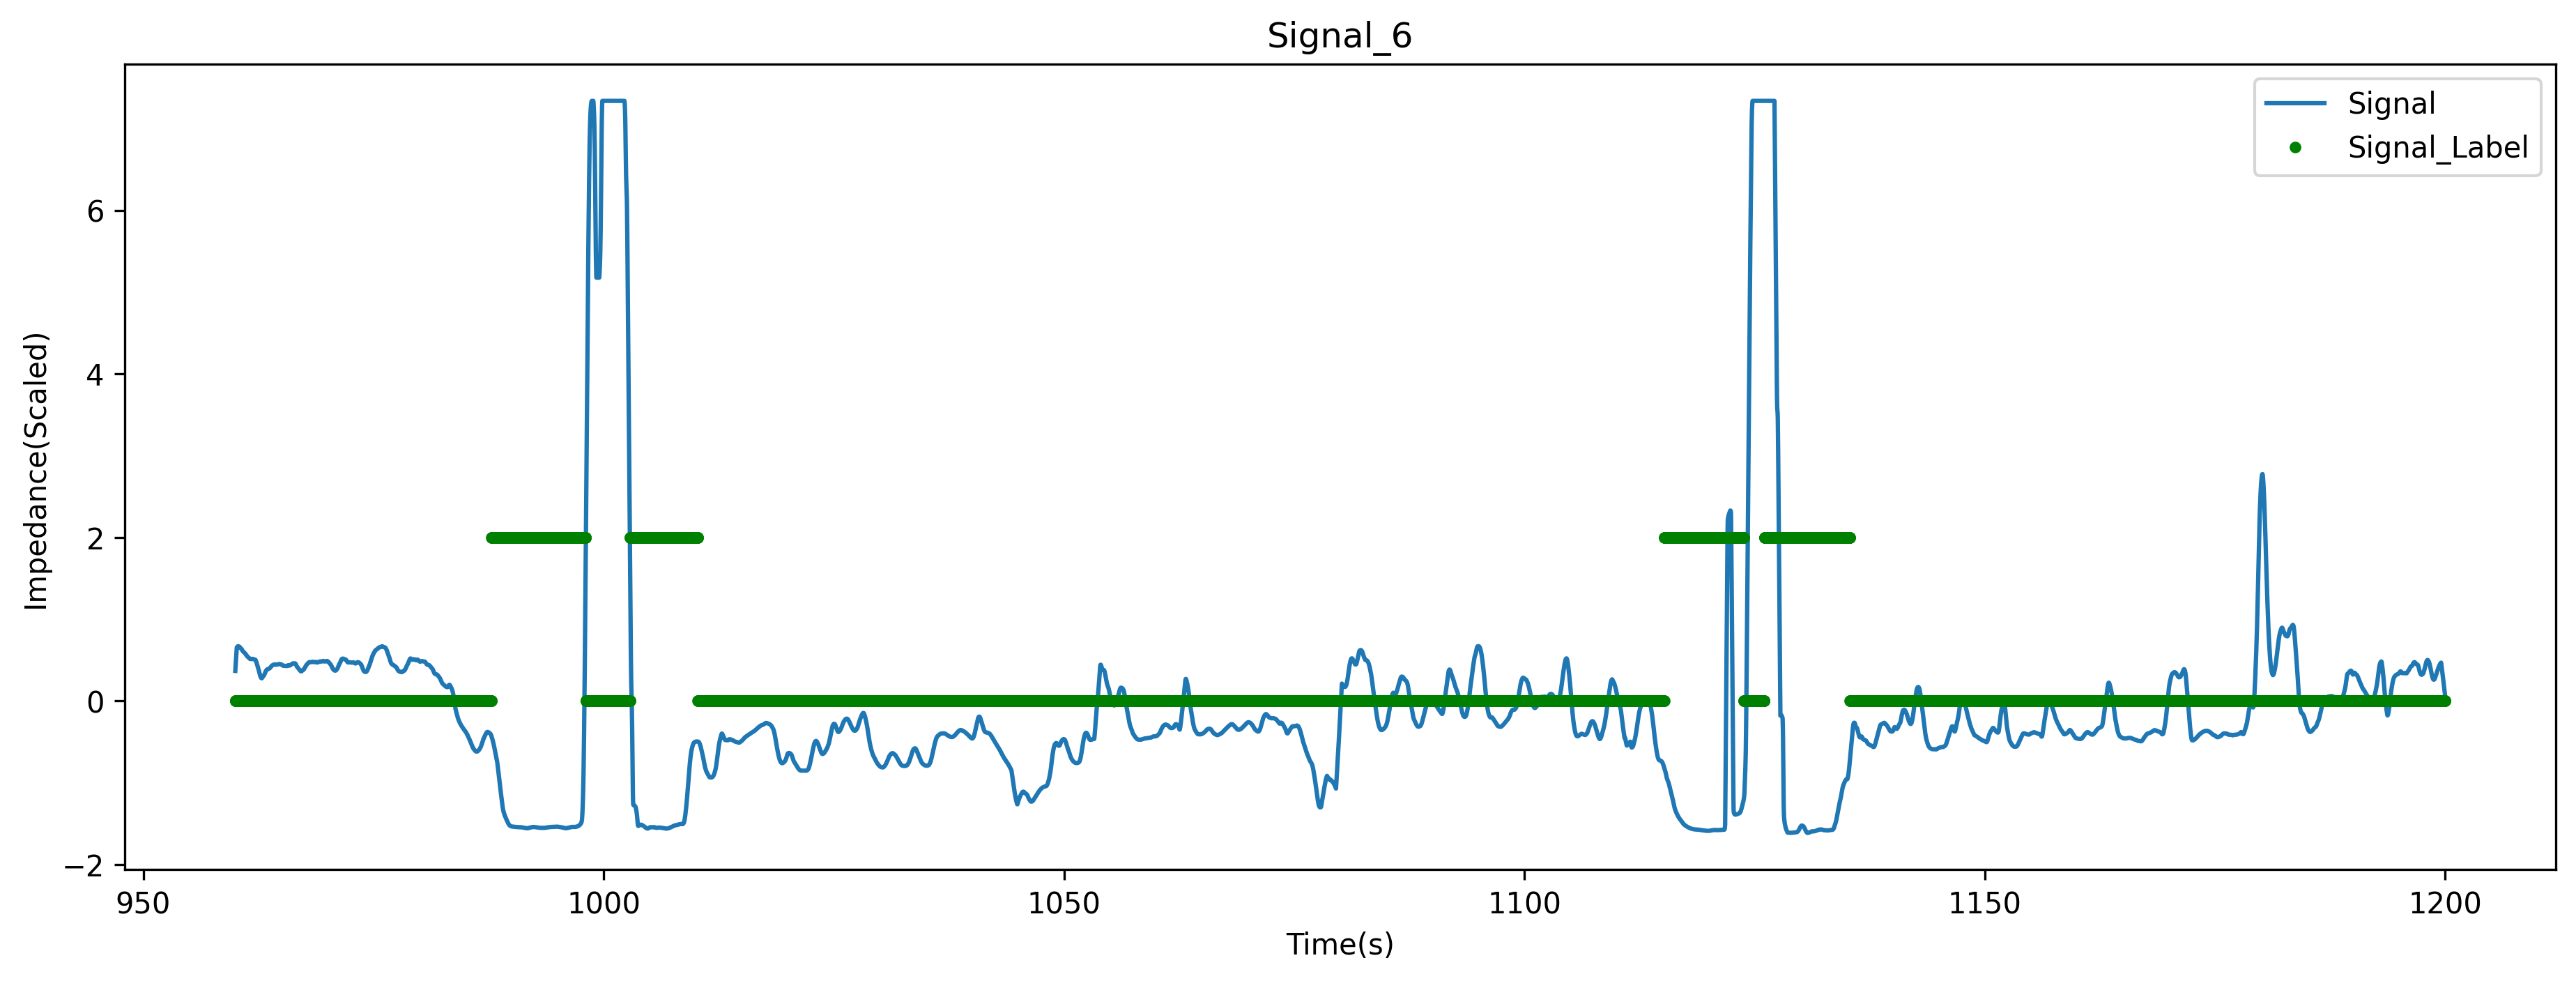

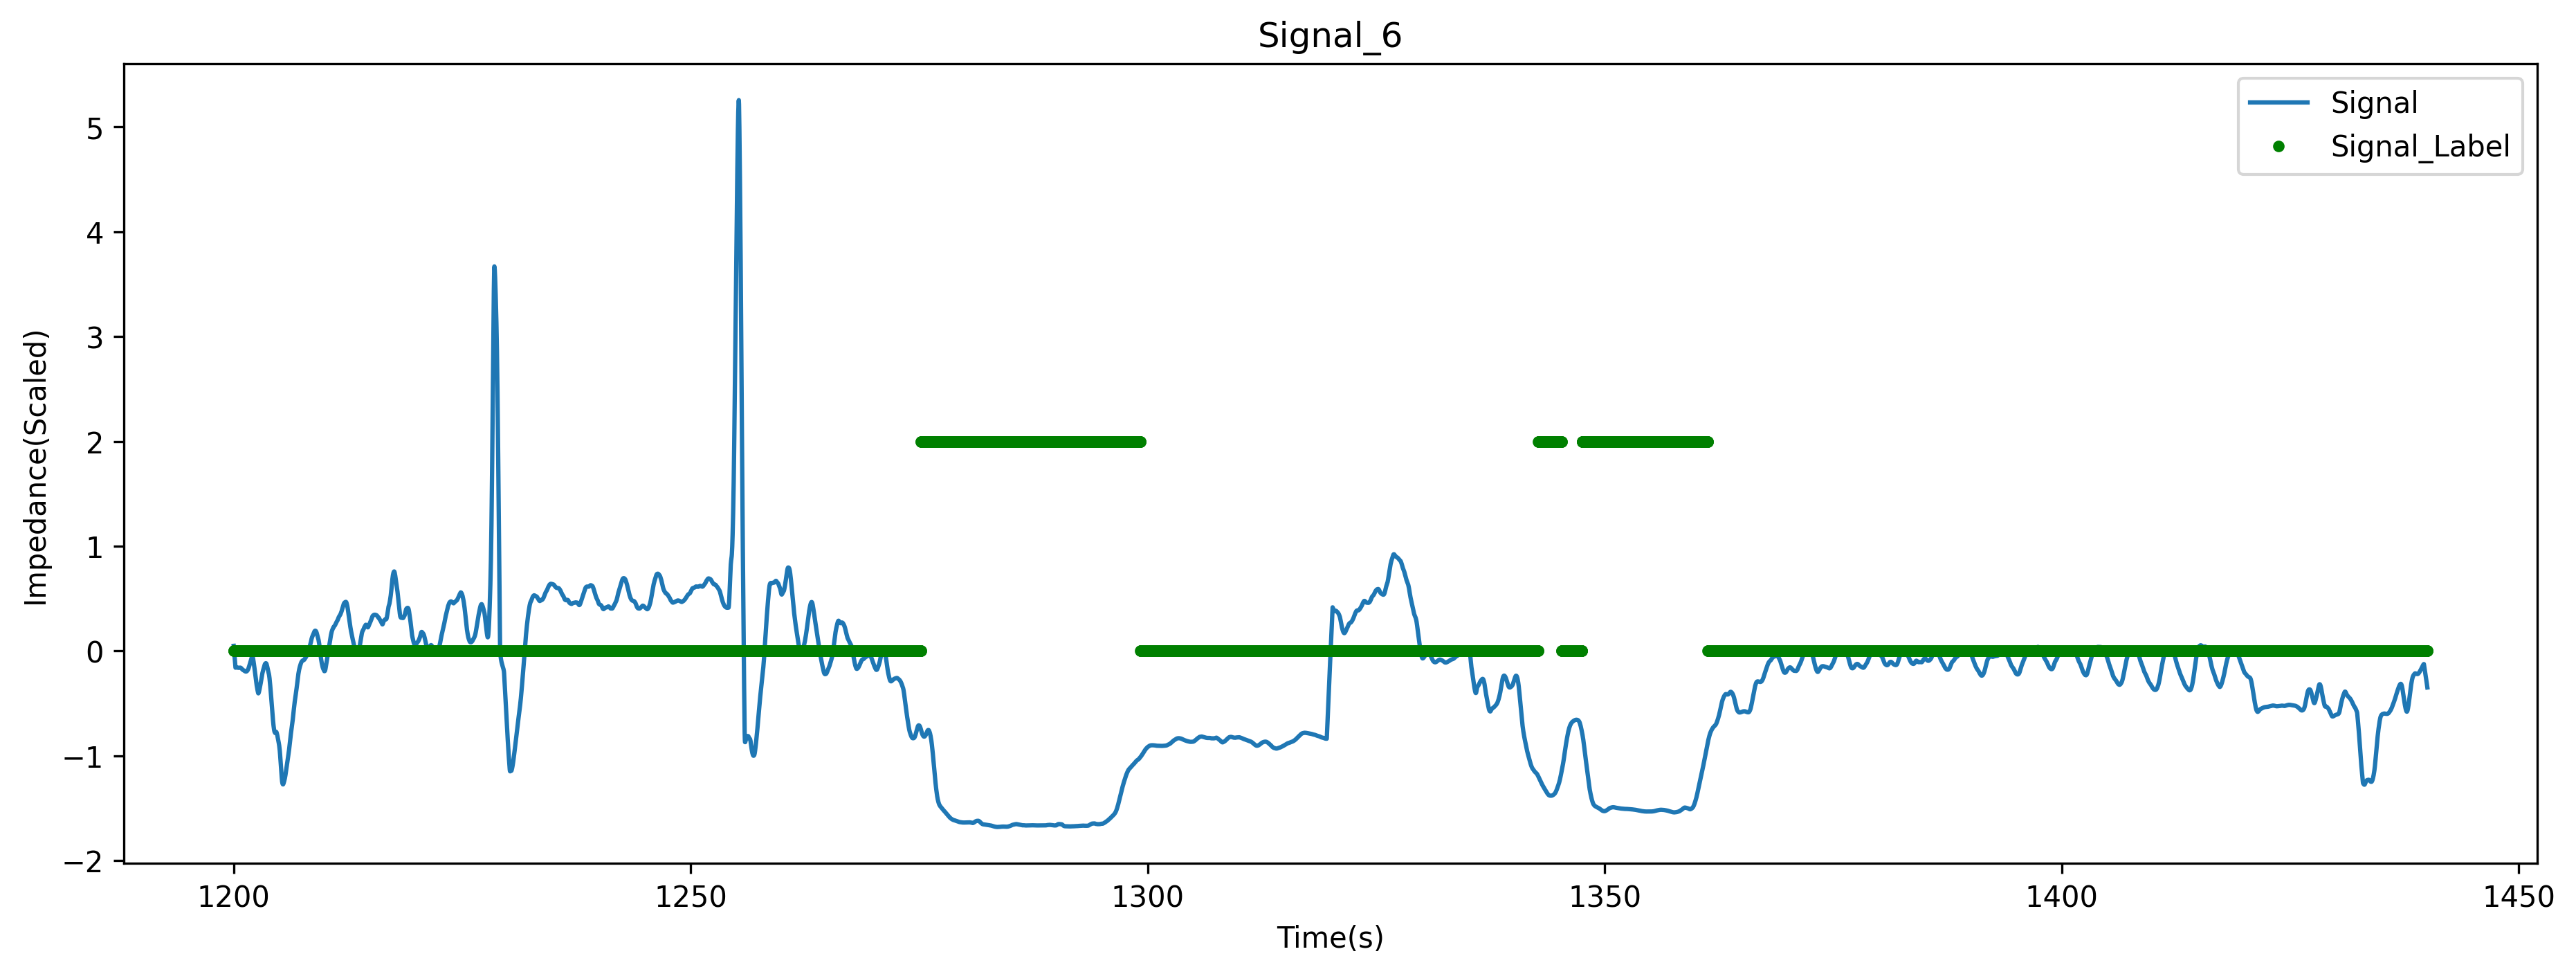

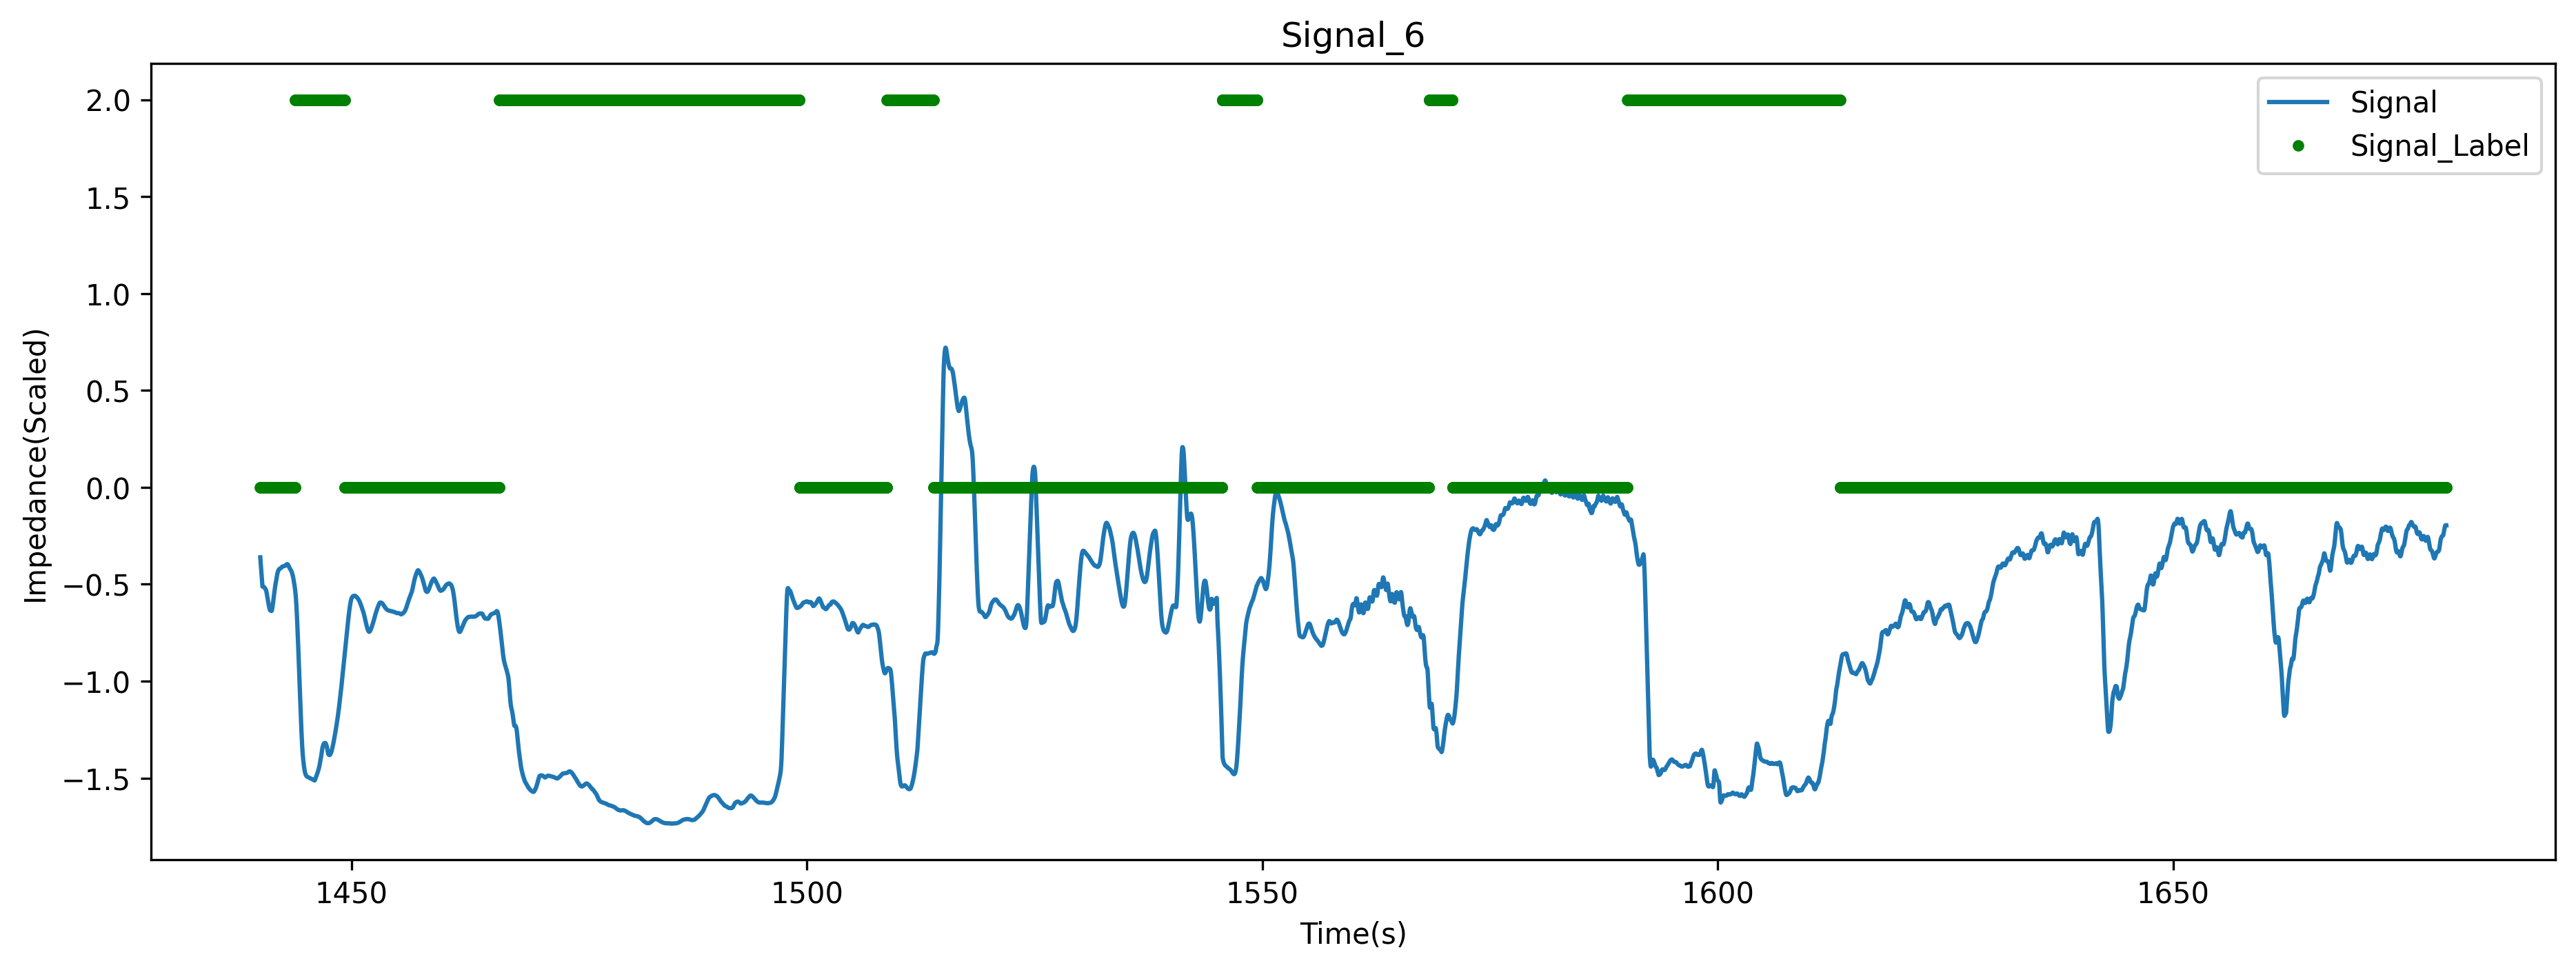

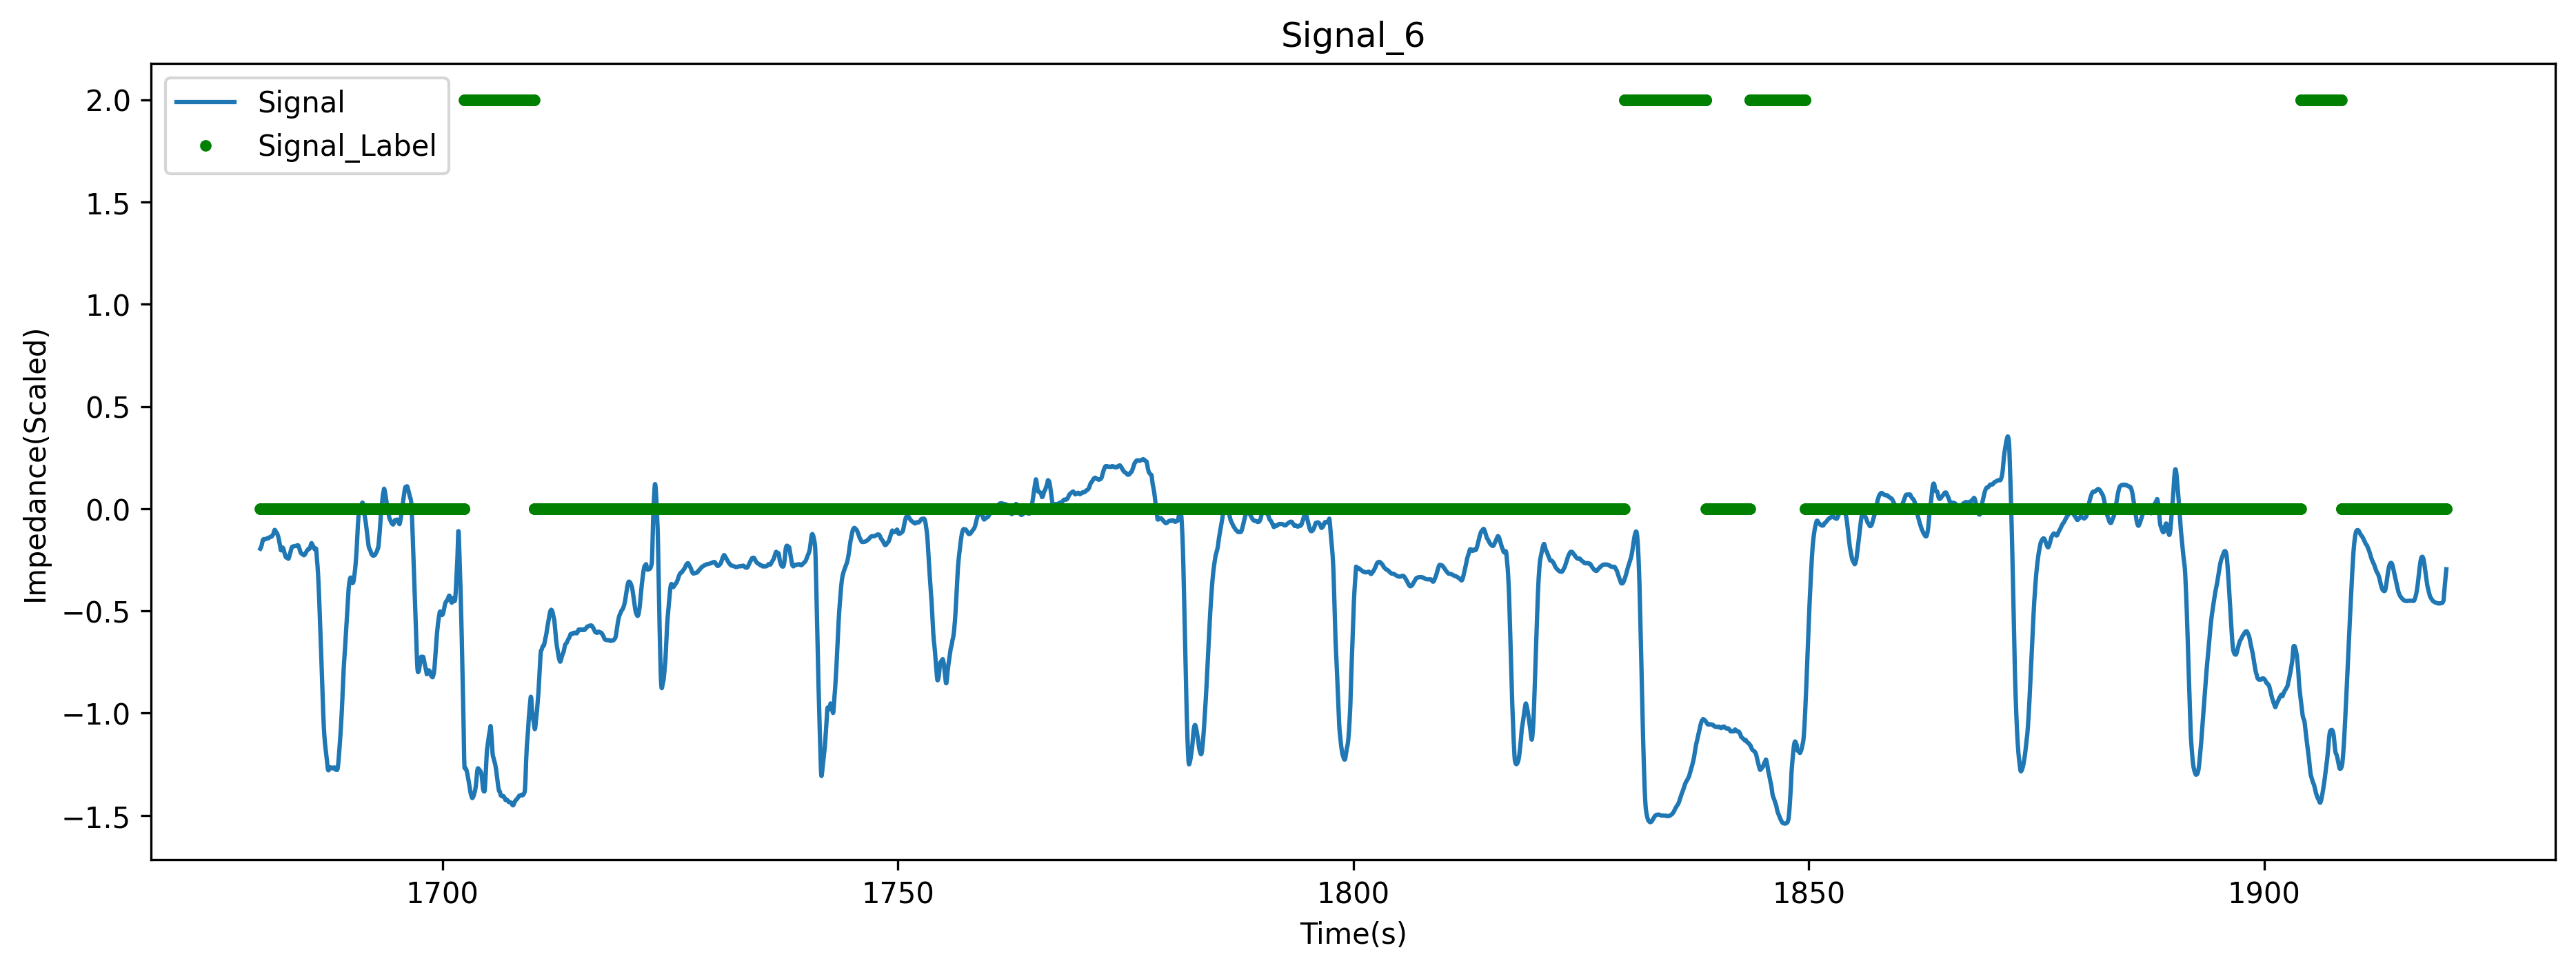

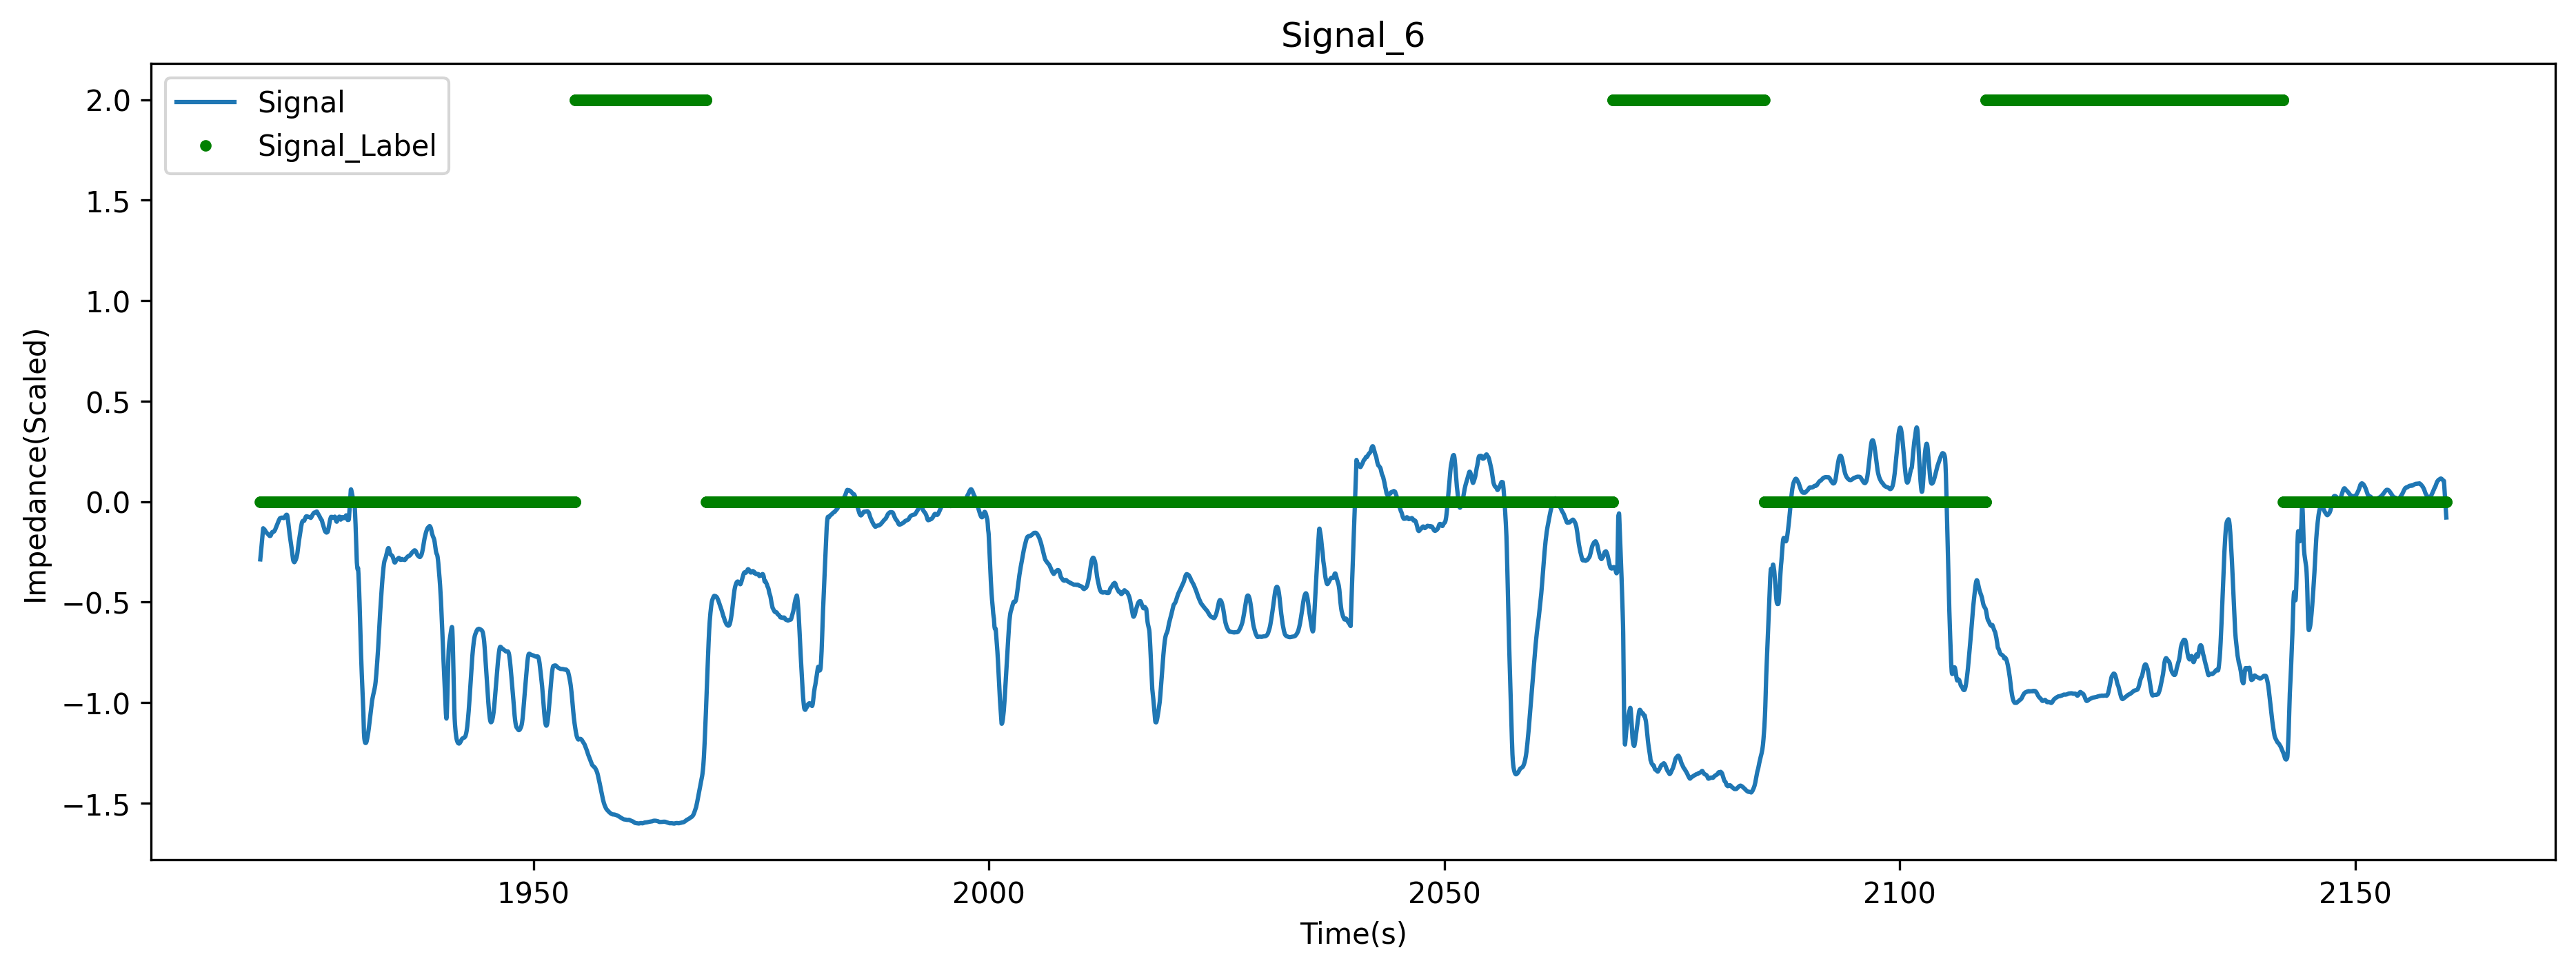

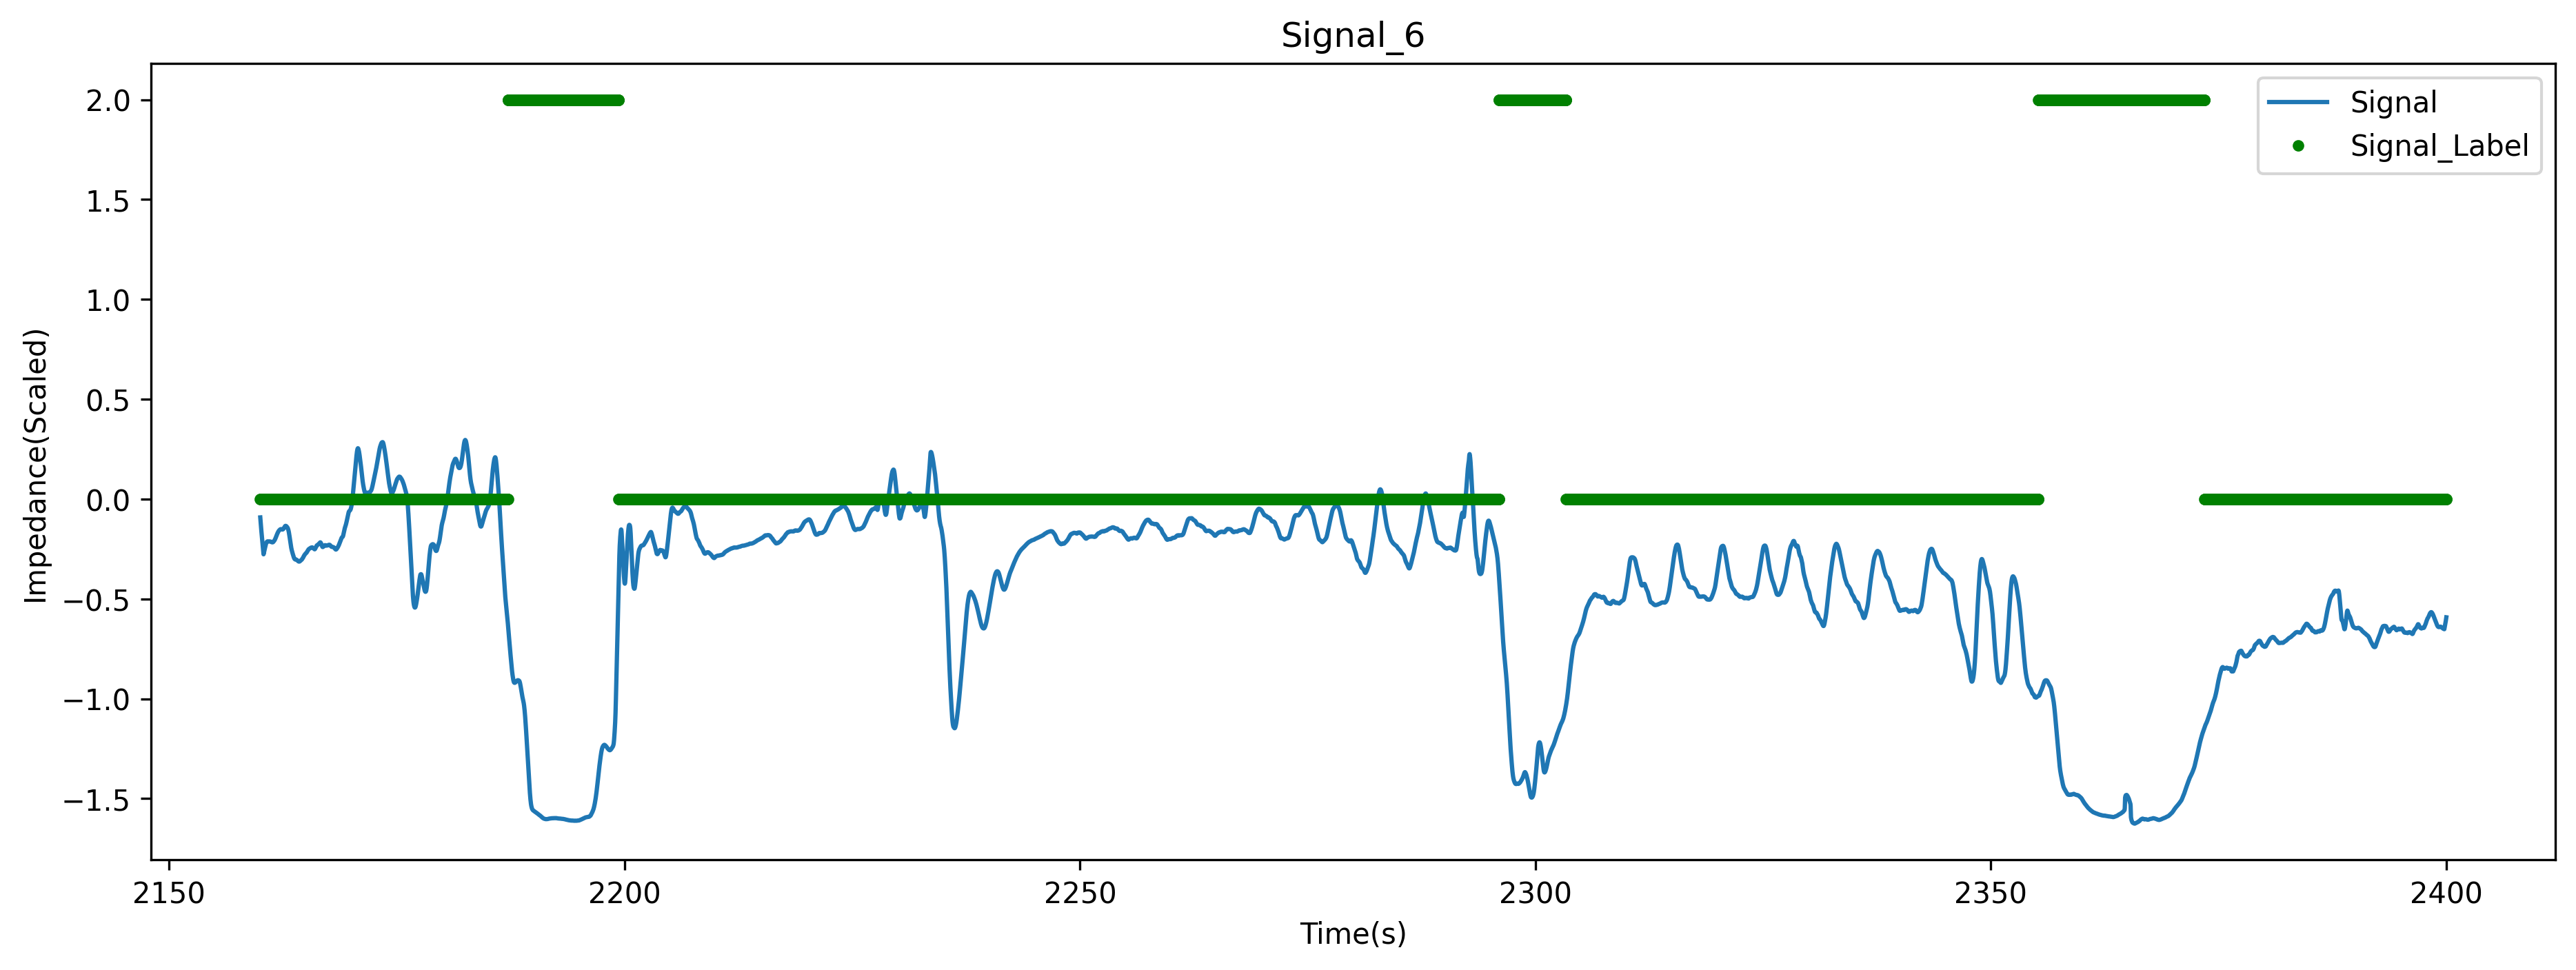

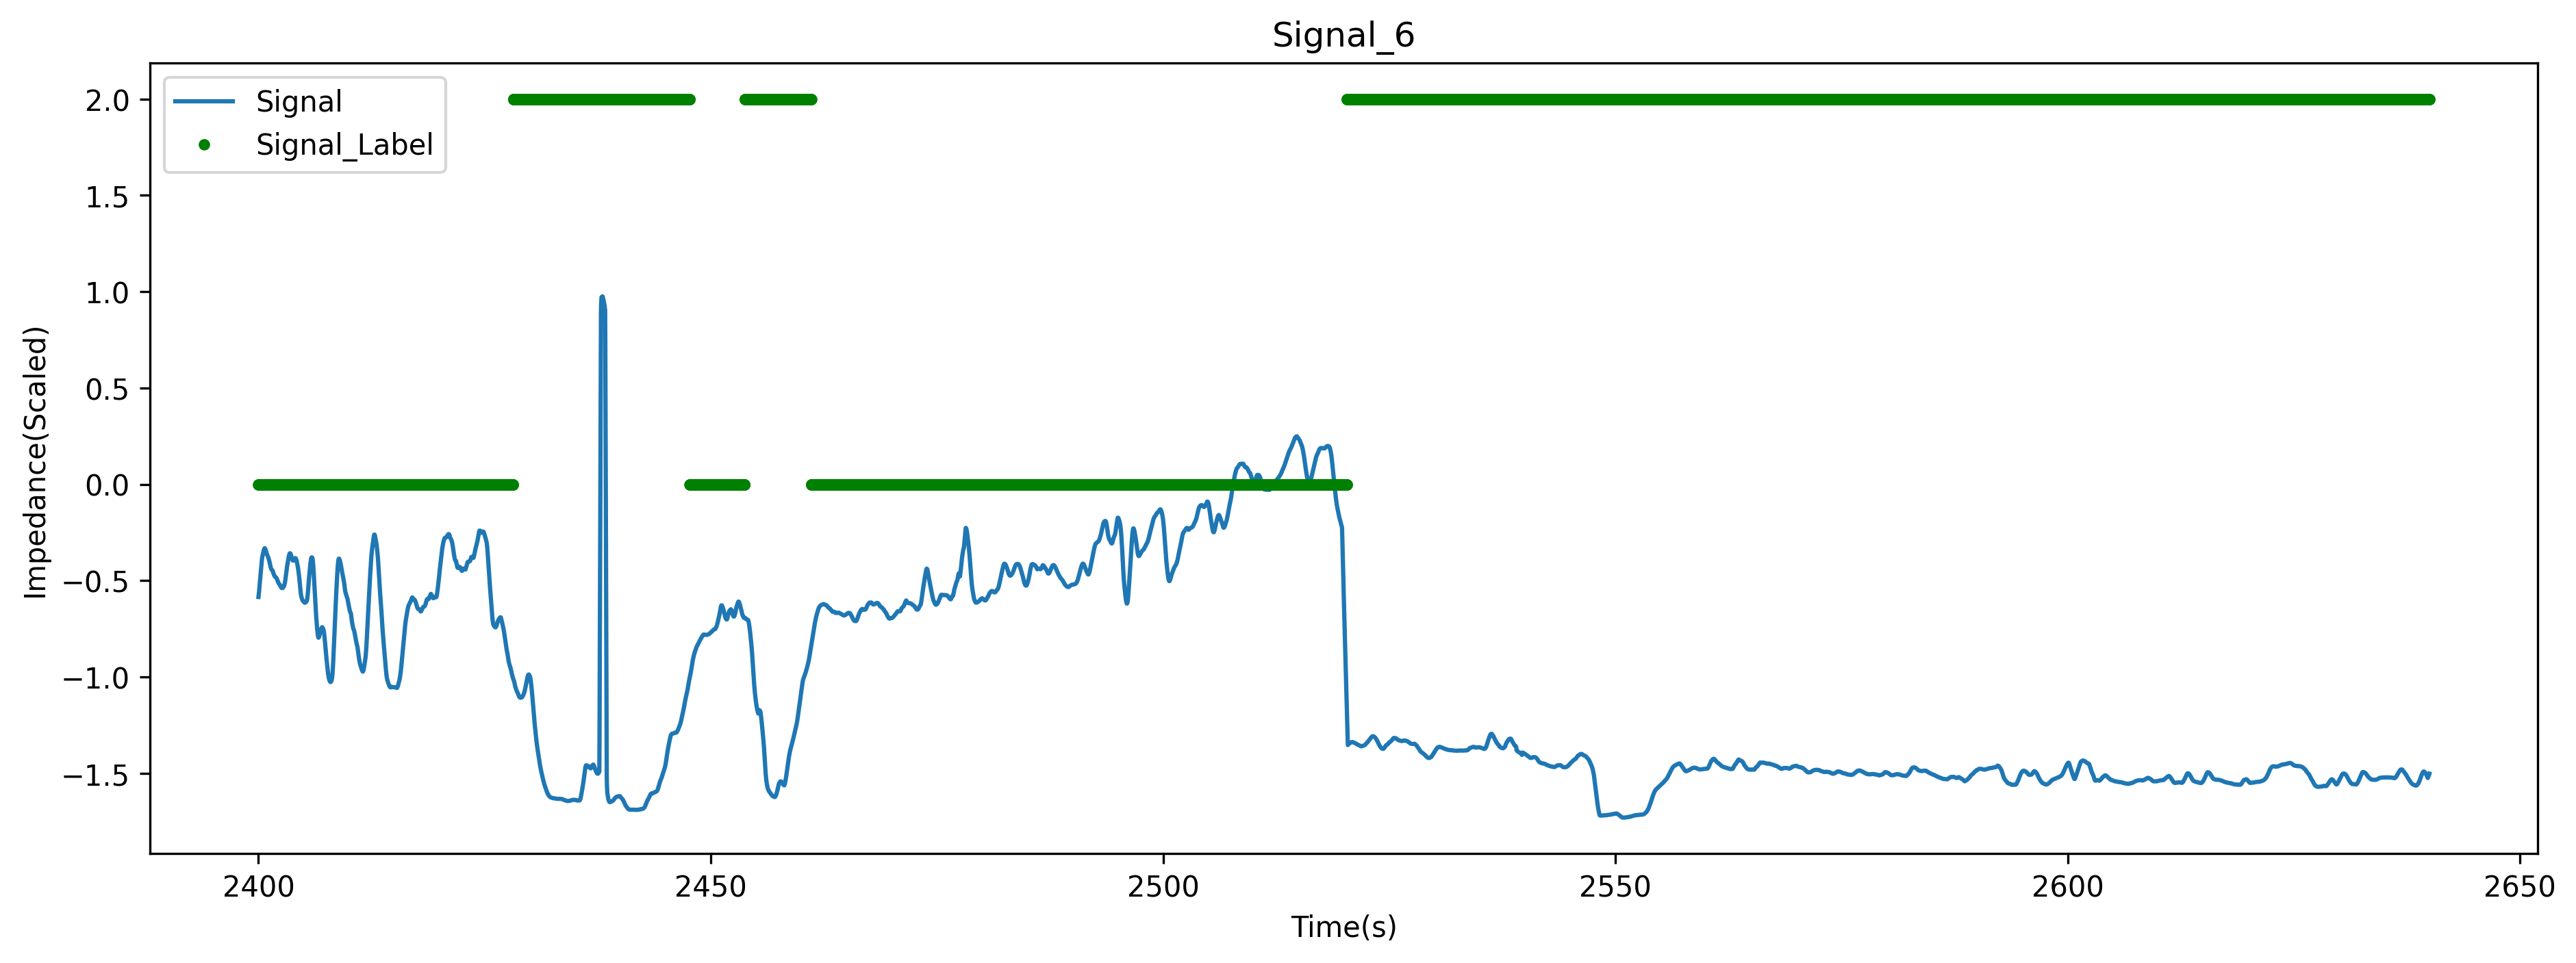

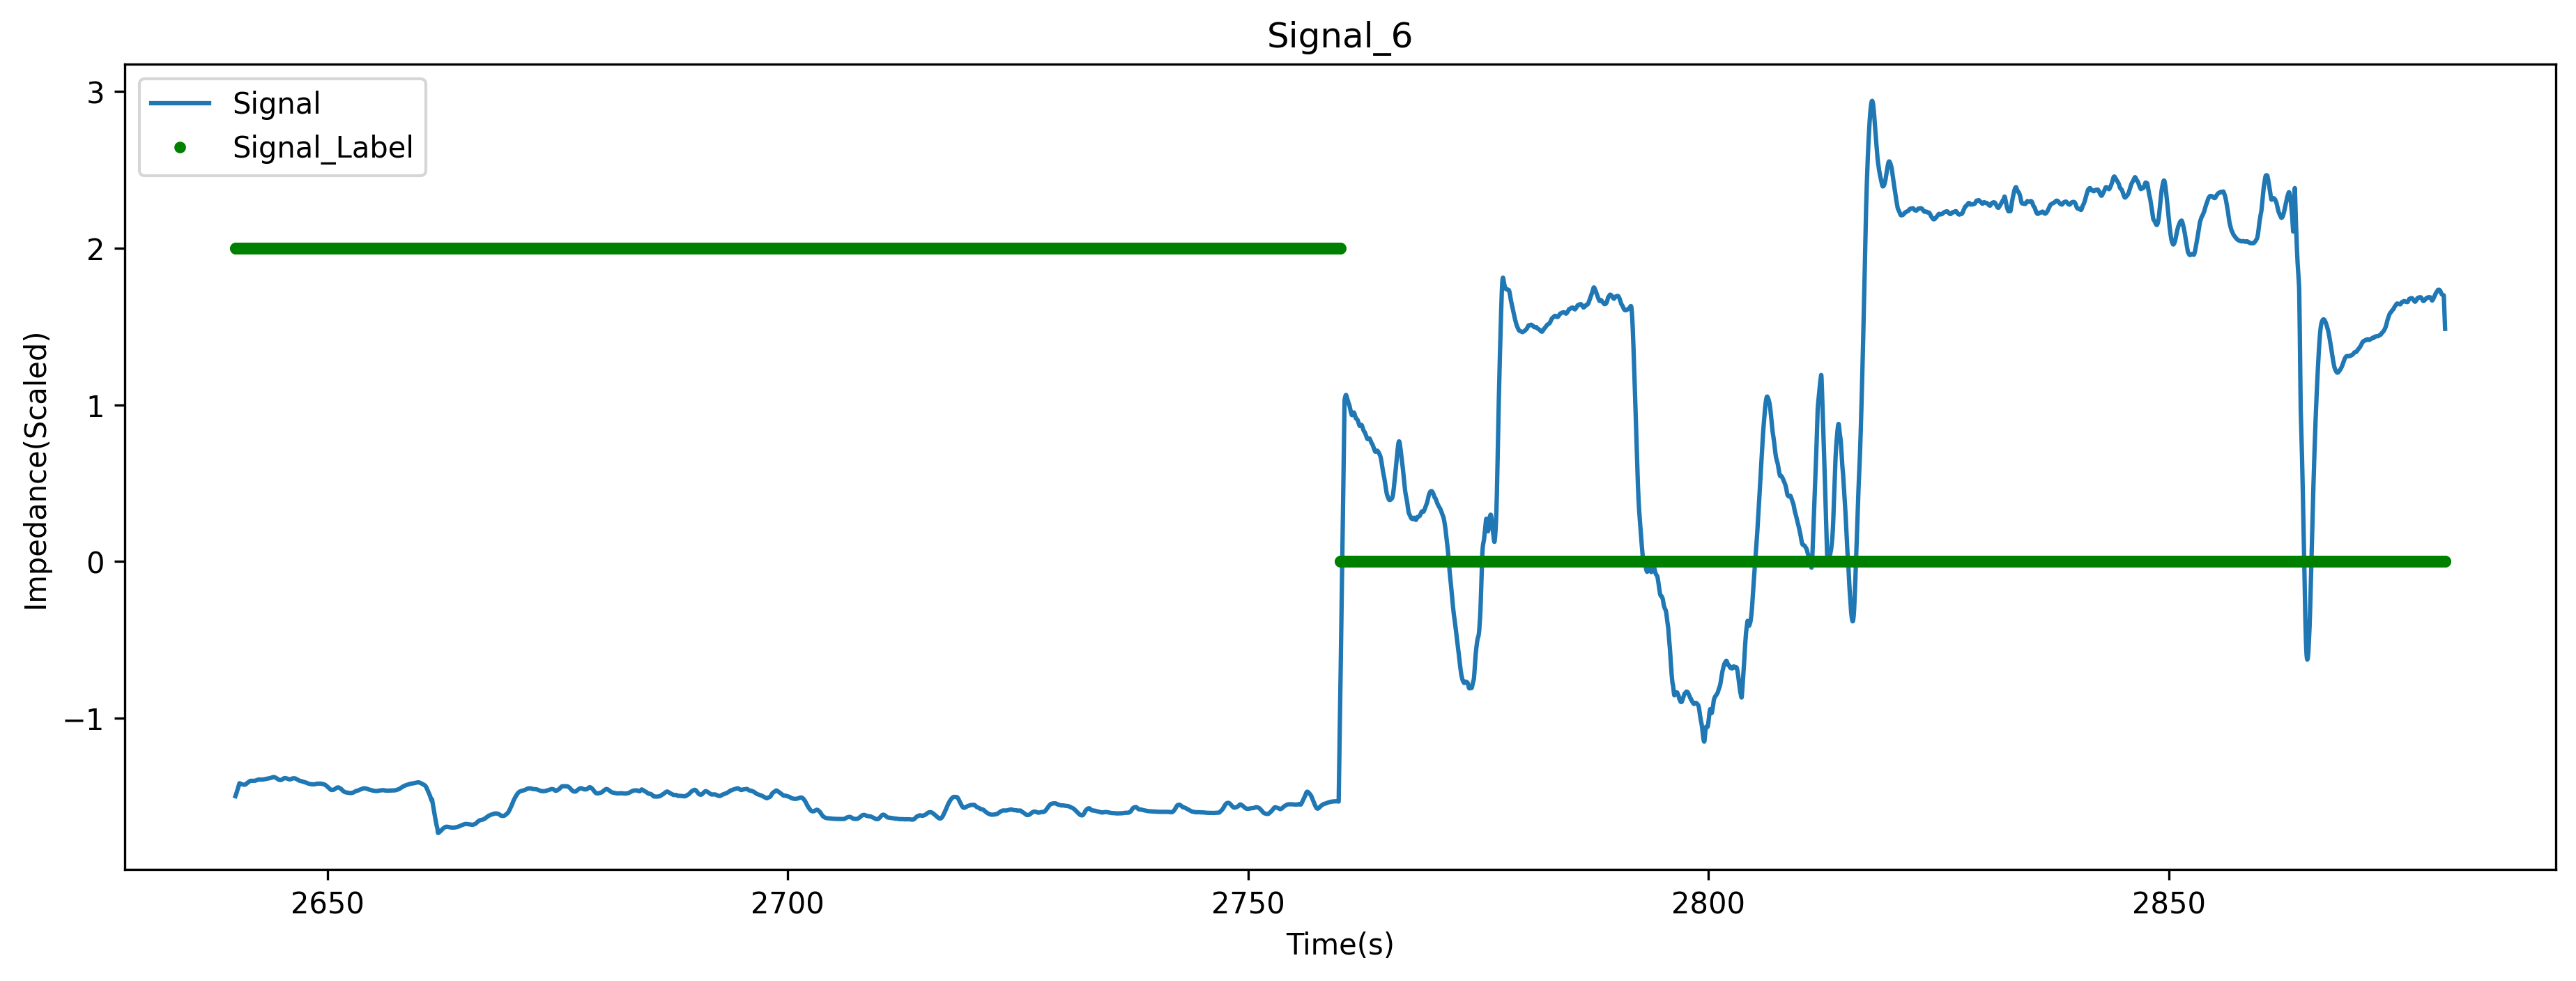

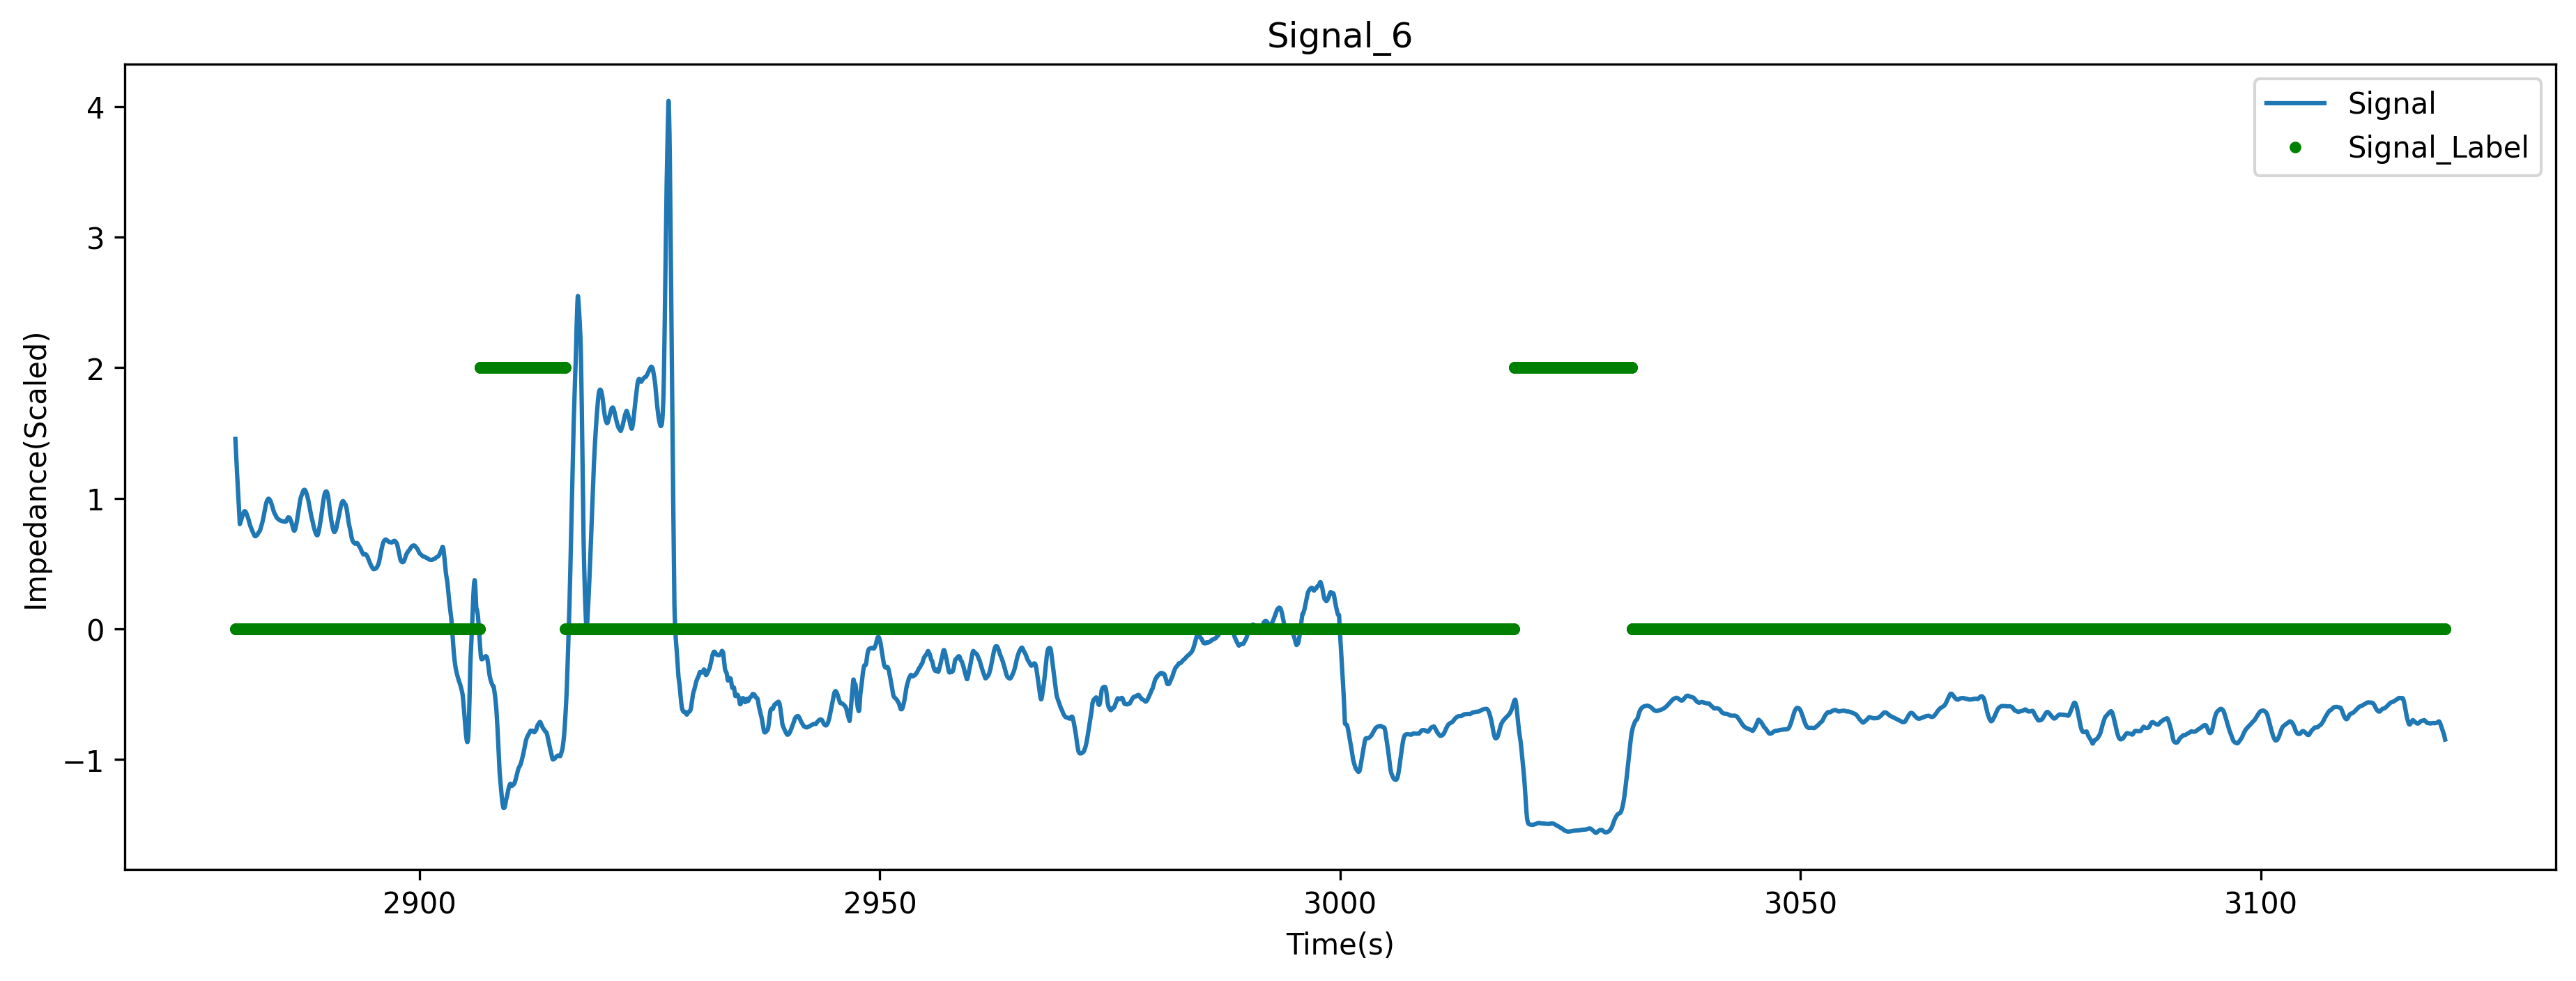

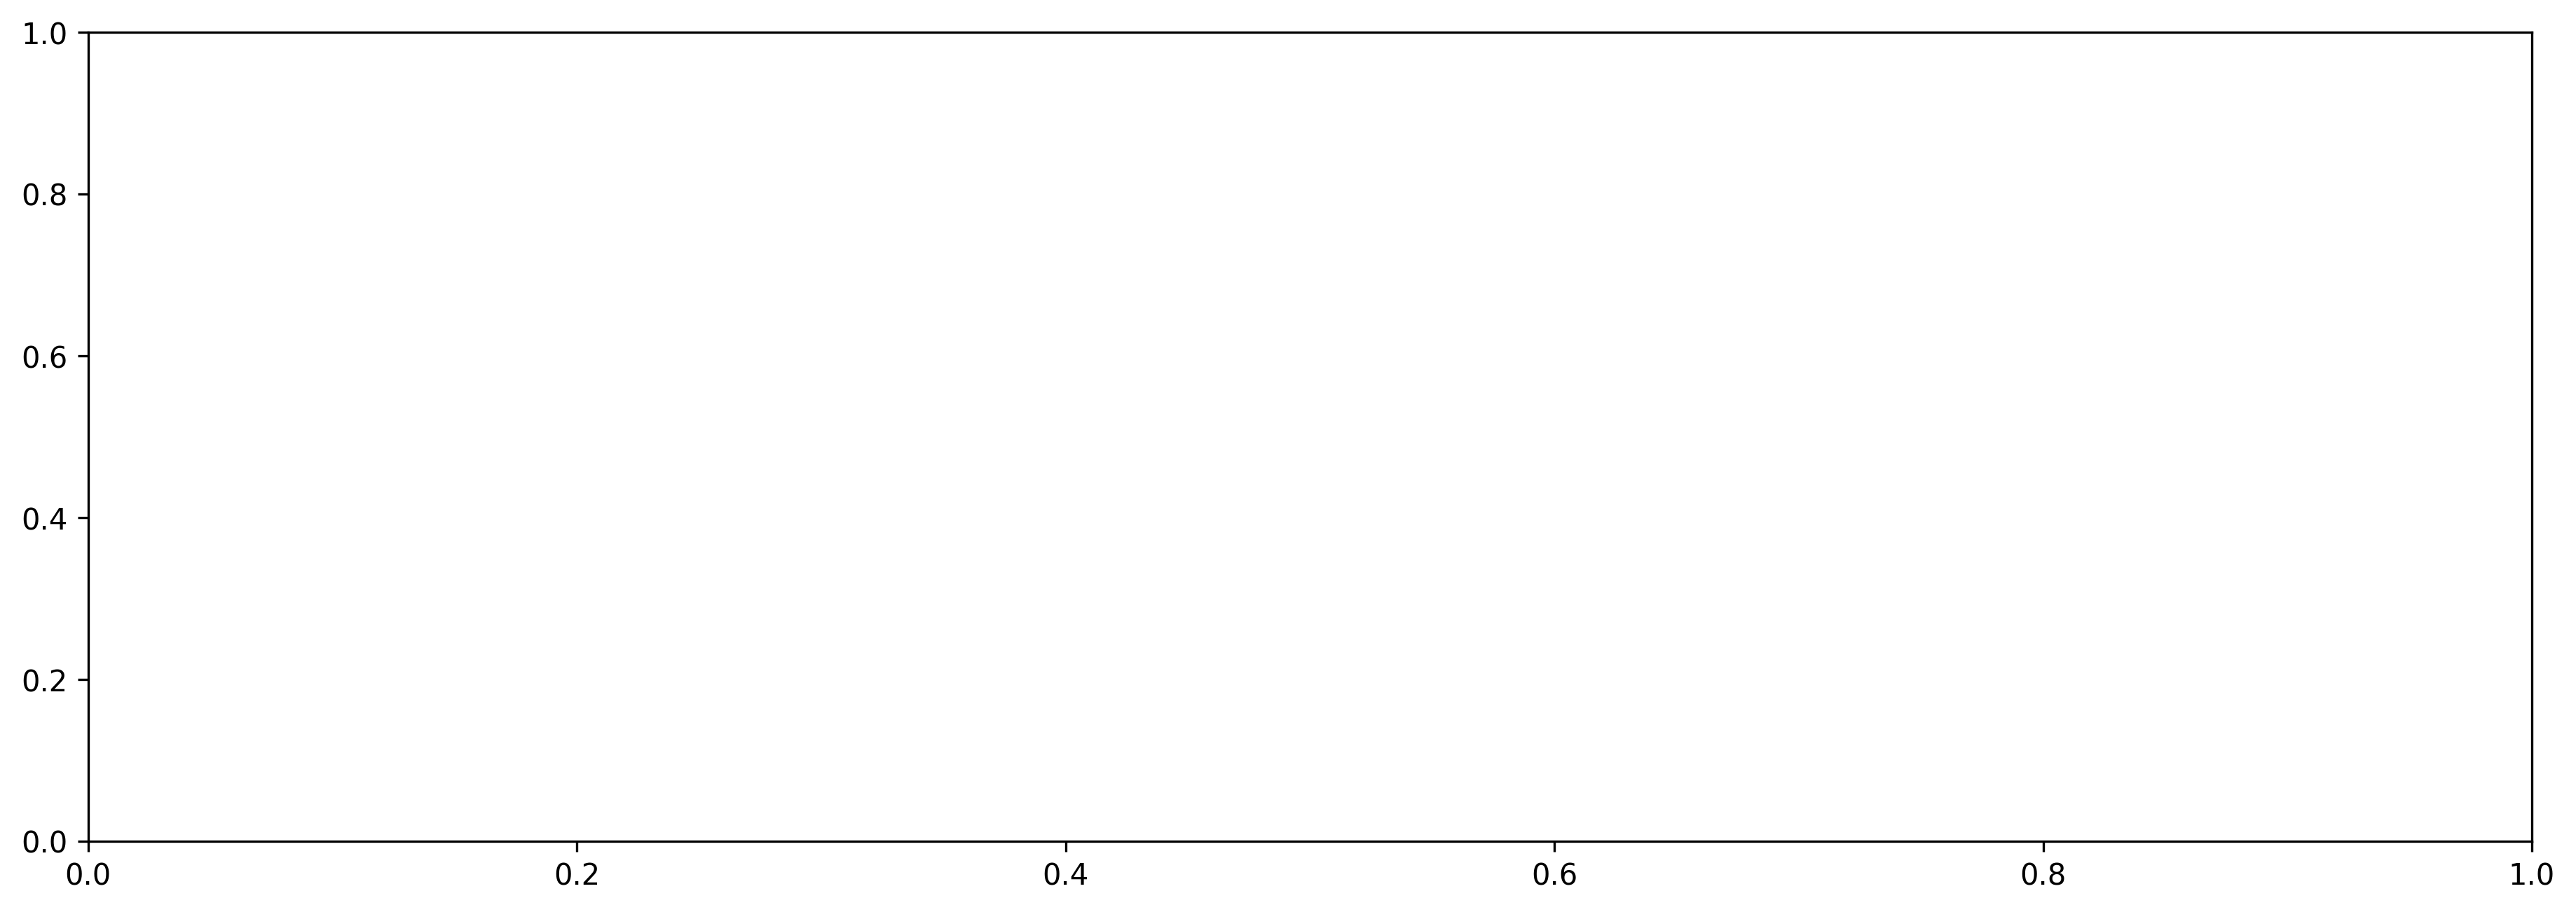

In [ ]:
for i in range(0,100):
    try:
        hz = 50
        TIME_INTERVAL = i

        start_time = TIME_INTERVAL * 240
        end_time = (TIME_INTERVAL + 1) * 240
        number_sample = (end_time - start_time) * hz
        start_sample = start_time * hz
        end_sample = end_time * hz

        label = df_labels.label_6.values[start_sample: end_sample]
        time = np.linspace(start_time, end_time, number_sample)
        plt.figure(figsize=(15, 5), dpi=300)
        plt.plot(time,
                 df_test[f"signal_6"].values[start_sample: end_sample],
                 label="Signal")
        plt.plot(time, label*2,"g." ,label="Signal_Label")

        plt.xlabel("Time(s)")
        plt.ylabel("Impedance(Scaled)")
        plt.title(f"Signal_6")
        plt.legend()
        plt.show()
    except:
        break
